In [1]:
import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
from scipy.interpolate import interp1d
import scipy as sc
import matplotlib.cm as cm
from salishsea_tools import (nc_tools, gsw_calls, geo_tools, viz_tools)
import seabird
import cmocean as cmo
import gsw

from seabird.cnv import fCNV
import pandas as pd
import seaborn as sns
import matplotlib.gridspec as gridspec
import scipy.io
from matplotlib.offsetbox import AnchoredText
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size


from dateutil        import parser
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.cluster as cluster
import time
%matplotlib inline
sns.set_context('paper')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}
plt.style.use('seaborn')


In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
NEP = nc.Dataset('/data/ssahu/NEP36_Extracted_Months/NEP36_2013_T_S_Spice_larger_offshore_rho_correct.nc')


sal = NEP.variables['vosaline']
temp = NEP.variables['votemper']
spic = NEP.variables['spiciness']
rho = NEP.variables['density']

zlevels = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/CDF_COMB_COMPRESSED/NEP036-N30_IN_20140915_00001440_grid_T.nc').variables['deptht'][:32]

mask = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/mesh_mask.nc')

tmask = mask.variables['tmask'][0,:32,180:350, 480:650]
umask = mask.variables['umask'][0,:32,180:350, 480:650]
vmask = mask.variables['vmask'][0,:32,180:350, 480:650]
mbathy = mask.variables['mbathy'][0,180:350, 480:650]


y_wcvi_slice = np.array(np.arange(180,350))
x_wcvi_slice = np.array(np.arange(480,650))




file_model = nc.Dataset('/data/ssahu/NEP36_2013_summer_hindcast/cut_NEP36-S29_1d_20130429_20131025_grid_T_20130429-20130508.nc')

lon = file_model.variables['nav_lon'][1:,1:]
lat = file_model.variables['nav_lat'][1:,1:]



lon_gsw = np.mean(lon)
lat_gsw = np.mean(lat)

In [3]:
path_of_file = '/data/ssahu/Falkor_2013/mvp/'

survey_file_A = path_of_file + 'surveyA.mat'
survey_file_B = path_of_file + 'surveyB.mat'
survey_file_D = path_of_file + 'surveyD.mat'
survey_file_E = path_of_file + 'surveyE.mat'
survey_file_G = path_of_file + 'surveyG.mat'

survey_file = [survey_file_A, survey_file_B, survey_file_D, survey_file_E, survey_file_G]

In [4]:
def MVP_survey_T_S_output_for_plot(file, SA_loc_cs_A, SA_loc_cs_B, SA_loc_cs_D, SA_loc_cs_E, SA_loc_cs_G,\
                                  CT_loc_cs_A, CT_loc_cs_B, CT_loc_cs_D, CT_loc_cs_E, CT_loc_cs_G):


    mat = scipy.io.loadmat(file)

    depths_survey = mat['depths'][:,0]
    lat_survey = mat['latitude'][:,0]
    lon_survey = mat['longitude'][:,0] - 100
    # den_survey = mat['density'][:]
    pden_survey = mat['pden'][:]
    temp_survey = mat['temp'][:]
    sal_survey = mat['salinity'][:]
    mtime = mat['mtime'][:,0]





    file_model = nc.Dataset('/data/ssahu/NEP36_2013_summer_hindcast/cut_NEP36-S29_1d_20130429_20131025_grid_T_20130429-20130508.nc')

    lon = file_model.variables['nav_lon'][1:,1:]
    lat = file_model.variables['nav_lat'][1:,1:]



    lon_gsw = np.mean(lon)
    lat_gsw = np.mean(lat)


    pressure_survey = np.empty_like(temp_survey)
    SA_survey = np.empty_like(temp_survey)
    CT_survey = np.empty_like(temp_survey)
    spic_survey = np.empty_like(temp_survey)
    rho_survey = np.empty_like(temp_survey)

    for j in np.arange(depths_survey.shape[0]):

        for i in np.arange(lat_survey.shape[0]):

            pressure_survey[j,i] = gsw.p_from_z(-depths_survey[j],lat_survey[i])

            SA_survey[j,i] = gsw.SA_from_SP(sal_survey[j,i], pressure_survey[j,i], lon_survey[i], lat_survey[i])

            CT_survey[j,i] = gsw.CT_from_pt(sal_survey[j,i], temp_survey[j,i])

            spic_survey[j,i] = gsw.spiciness0(SA_survey[j,i], CT_survey[j,i])

            rho_survey[j,i] = gsw.density.rho(SA_survey[j,i], CT_survey[j,i], 0)


    y = np.empty_like(lat_survey)
    x = np.empty_like(y)


    for i in np.arange(lat_survey.shape[0]):
        y[i], x[i] = geo_tools.find_closest_model_point(
                   lon_survey[i],lat_survey[i],lon,lat,tols={
            'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})


    SA_loc_cs = []
    CT_loc_cs = []

    for i in np.arange(sal_survey.shape[1]):
        SA_loc_cs = np.append(arr=SA_loc_cs, values= sal_survey[:,i][np.isfinite(sal_survey[:,i])])
        CT_loc_cs = np.append(arr=CT_loc_cs, values= temp_survey[:,i][~np.isnan(temp_survey[:,i])])

    if file[28:35] == 'surveyA':    
        SA_loc_cs_A = SA_loc_cs
        CT_loc_cs_A = CT_loc_cs

    if file[28:35] == 'surveyB':    
        SA_loc_cs_B = SA_loc_cs
        CT_loc_cs_B = CT_loc_cs

    if file[28:35] == 'surveyD':    
        SA_loc_cs_D = SA_loc_cs
        CT_loc_cs_D = CT_loc_cs

    if file[28:35] == 'surveyE':    
        SA_loc_cs_E = SA_loc_cs
        CT_loc_cs_E = CT_loc_cs    

    if file[28:35] == 'surveyG':    
        SA_loc_cs_G = SA_loc_cs
        CT_loc_cs_G = CT_loc_cs  
        
    return SA_loc_cs_A, CT_loc_cs_A, SA_loc_cs_B, CT_loc_cs_B, \
SA_loc_cs_D, CT_loc_cs_D, SA_loc_cs_E, CT_loc_cs_E, \
SA_loc_cs_G, CT_loc_cs_G

In [5]:
SA_loc_cs_A = []; SA_loc_cs_B = []; SA_loc_cs_D = []; SA_loc_cs_E = []; SA_loc_cs_G = []
CT_loc_cs_A = []; CT_loc_cs_B = []; CT_loc_cs_D = []; CT_loc_cs_E = []; CT_loc_cs_G = []


for file in survey_file:

    SA_loc_cs_A, CT_loc_cs_A, SA_loc_cs_B, CT_loc_cs_B, \
    SA_loc_cs_D, CT_loc_cs_D, SA_loc_cs_E, CT_loc_cs_E, \
    SA_loc_cs_G, CT_loc_cs_G = MVP_survey_T_S_output_for_plot(file, SA_loc_cs_A=SA_loc_cs_A, SA_loc_cs_B=SA_loc_cs_B,\
                                                             SA_loc_cs_D=SA_loc_cs_D, SA_loc_cs_E=SA_loc_cs_E,\
                                                             SA_loc_cs_G=SA_loc_cs_G, CT_loc_cs_A = CT_loc_cs_A, CT_loc_cs_B = CT_loc_cs_B,\
                                                             CT_loc_cs_D = CT_loc_cs_D, CT_loc_cs_E =CT_loc_cs_E, \
                                                             CT_loc_cs_G = CT_loc_cs_G)

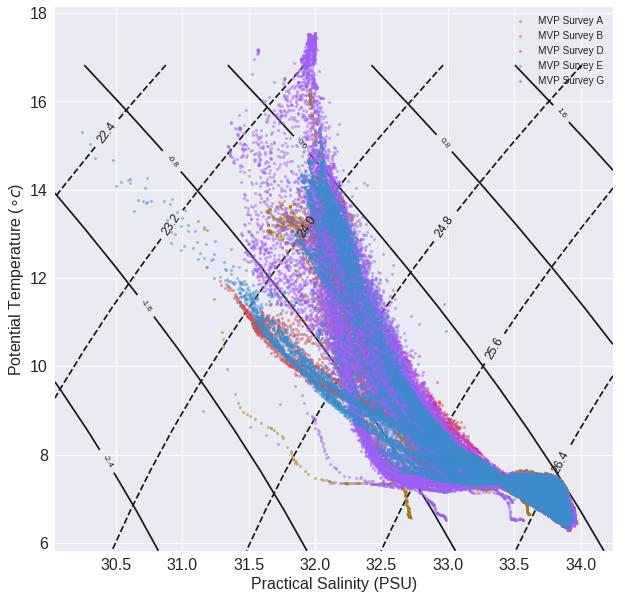

In [7]:
colors = cmo.cm.phase(np.linspace(0, 1, 203))

SA_loc_cs_D1 = SA_loc_cs_D[SA_loc_cs_D>30]
CT_loc_cs_D1 = CT_loc_cs_D[SA_loc_cs_D>30]

# Figure out boudaries (mins and maxs)
smin = SA_loc_cs_G.min() - (0.01 * SA_loc_cs_G.min())
smax = SA_loc_cs_G.max() + (0.01 * SA_loc_cs_G.max())
tmin = CT_loc_cs_G.min() - (0.1 * CT_loc_cs_G.max())
tmax = CT_loc_cs_G.max() + (0.1 * CT_loc_cs_G.max())
 
# Calculate how many gridcells we need in the x and y dimensions
xdim = int(round((smax-smin)/0.1+1,0))
ydim = int(round((tmax-tmin)+1,0))
 
# Create empty grid of zeros
dens_1 = np.empty((ydim,xdim))
spic_1 = np.empty((ydim,xdim))
SA = np.empty((xdim))
CT = np.empty((ydim)) 
# Create temp and salt vectors of appropiate dimensions
ti = np.linspace(1,ydim-1,ydim)+tmin
si = np.linspace(1,xdim-1,xdim)*0.1+smin
 
# Loop to fill in grid with densities
for j in range(0,int(ydim)):
    for i in range(0, int(xdim)):
        
        SA[i] = gsw.SA_from_SP(si[i], 0, lon_gsw, lat_gsw)

        CT[j] = gsw.CT_from_pt(si[i], ti[j])
        
        dens_1[j,i]=gsw.rho(SA[i],CT[j],0)
        
        spic_1[j,i] = gsw.spiciness0(SA[i],CT[j])
 
# Substract 1000 to convert to sigma-t
dens_1 = dens_1 - 1000
 
# Plot data ***********************************************
fig1, ax = plt.subplots(1, 1, figsize=(10,10))
CS = plt.contour(si,ti,dens_1, linestyles='dashed', colors='k')
CS1 = plt.contour(si,ti,spic_1, linestyles='solid', colors='k')
plt.clabel(CS, fontsize=12, inline=1, fmt='%0.1f') # Label every second level
plt.clabel(CS1, fontsize=8, inline=1, fmt='%0.1f') # Label every second level


ax.plot(SA_loc_cs_A ,CT_loc_cs_A,'o', color= colors[0,:], alpha = 0.5, markersize=3, label='MVP Survey A')

ax.plot(SA_loc_cs_B ,CT_loc_cs_B, 'o',color= colors[30,:],alpha = 0.5,  markersize=3, label='MVP Survey B')

ax.plot(SA_loc_cs_D1 ,CT_loc_cs_D1, 'o',color= colors[60,:],alpha = 0.5,  markersize=3, label='MVP Survey D')

ax.plot(SA_loc_cs_E ,CT_loc_cs_E, 'o',color= colors[90,:], alpha = 0.5, markersize=3, label='MVP Survey E')

ax.plot(SA_loc_cs_G ,CT_loc_cs_G, 'o',color= colors[120,:], alpha = 0.5, markersize=3, label='MVP Survey G')

# ax.plot(SA_loc_f, CT_loc_f, 'o' ,markersize=9, label = 'Eddy west front')
# ax.set_ylim(5,18)
# ax.set_xlim(30,34)
 
ax.set_xlabel('Practical Salinity (PSU)', fontsize = 16)
ax.set_ylabel('Potential Temperature ($\circ c$)', fontsize = 16)
ax.tick_params(axis='both',labelsize =16)
# ax.set_xlim(31.5,)


legend = ax.legend(loc='upper right', fancybox=True, framealpha=0.25)

In [6]:
def model_data_MVP_survey_T_S_output_for_plot(file, model_survey_sal_A, model_survey_sal_B, model_survey_sal_D, model_survey_sal_E, model_survey_sal_G,\
                                  model_survey_temp_A, model_survey_temp_B, model_survey_temp_D, model_survey_temp_E, model_survey_temp_G):


    mat = scipy.io.loadmat(file)

    depths_survey = mat['depths'][:,0]
    lat_survey = mat['latitude'][:,0]
    lon_survey = mat['longitude'][:,0] - 100





    file_model = nc.Dataset('/data/ssahu/NEP36_2013_summer_hindcast/cut_NEP36-S29_1d_20130429_20131025_grid_T_20130429-20130508.nc')

    lon = file_model.variables['nav_lon'][1:,1:]
    lat = file_model.variables['nav_lat'][1:,1:]



    lon_gsw = np.mean(lon)
    lat_gsw = np.mean(lat)


    y = np.empty_like(lat_survey)
    x = np.empty_like(y)


    for i in np.arange(lat_survey.shape[0]):
        y[i], x[i] = geo_tools.find_closest_model_point(
                   lon_survey[i],lat_survey[i],lon,lat,tols={
            'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})

        
    model_survey_sal  = np.empty((sal.shape[1],y.shape[0]))
    model_survey_temp = np.empty_like(model_survey_sal)
    model_survey_rho  = np.empty_like(model_survey_sal)
    model_survey_spic = np.empty_like(model_survey_sal)

    if file[28:35] == 'surveyA':
        t =116
    if file[28:35] == 'surveyB':
        t =116
    if file[28:35] == 'surveyD':
        t =118
    if file[28:35] == 'surveyE':
        t =119
    if file[28:35] == 'surveyG':
        t =120


    for i in np.arange(y.shape[0]):
        model_survey_sal[:,i]   = sal[t,:,y[i],x[i]]
        model_survey_temp[:,i]  = temp[t,:,y[i],x[i]]
        model_survey_spic[:,i]  = spic[t,:,y[i],x[i]]
        model_survey_rho[:,i]   = rho[t,:,y[i],x[i]]

    model_survey_temp[model_survey_temp == 0] = np.nan
    model_survey_sal[model_survey_sal == 0] = np.nan
    model_survey_spic[model_survey_temp == 0] = np.nan
    model_survey_rho[model_survey_temp == 0]  = np.nan
    
    SA_loc_cs = []
    CT_loc_cs = []
    

    for i in np.arange(model_survey_sal.shape[1]):
        SA_loc_cs = np.append(arr=SA_loc_cs, values= model_survey_sal[:,i][np.isfinite(model_survey_sal[:,i])])
        CT_loc_cs = np.append(arr=CT_loc_cs, values= model_survey_temp[:,i][~np.isnan(model_survey_temp[:,i])])


    if file[28:35] == 'surveyA':    
        model_survey_temp_A = CT_loc_cs
        model_survey_sal_A = SA_loc_cs

    if file[28:35] == 'surveyB':    
        model_survey_sal_B = SA_loc_cs
        model_survey_temp_B = CT_loc_cs

    if file[28:35] == 'surveyD':    
        model_survey_sal_D = SA_loc_cs
        model_survey_temp_D = CT_loc_cs

    if file[28:35] == 'surveyE':    
        model_survey_sal_E = SA_loc_cs
        model_survey_temp_E = CT_loc_cs   

    if file[28:35] == 'surveyG':    
        model_survey_sal_G = SA_loc_cs
        model_survey_temp_G = CT_loc_cs 
        
    return model_survey_sal_A, model_survey_temp_A, model_survey_sal_B, model_survey_temp_B, \
model_survey_sal_D, model_survey_temp_D, model_survey_sal_E, model_survey_temp_E, \
model_survey_sal_G, model_survey_temp_G

In [7]:
def model_spice_density_MVP_survey_T_S_output_for_plot(file, model_survey_spic_A, model_survey_spic_B, model_survey_spic_D, model_survey_spic_E, model_survey_spic_G,\
                                                       model_survey_rho_A, model_survey_rho_B, model_survey_rho_D, model_survey_rho_E, model_survey_rho_G):


    mat = scipy.io.loadmat(file)

    depths_survey = mat['depths'][:,0]
    lat_survey = mat['latitude'][:,0]
    lon_survey = mat['longitude'][:,0] - 100





    file_model = nc.Dataset('/data/ssahu/NEP36_2013_summer_hindcast/cut_NEP36-S29_1d_20130429_20131025_grid_T_20130429-20130508.nc')

    lon = file_model.variables['nav_lon'][1:,1:]
    lat = file_model.variables['nav_lat'][1:,1:]



    lon_gsw = np.mean(lon)
    lat_gsw = np.mean(lat)


    y = np.empty_like(lat_survey)
    x = np.empty_like(y)


    for i in np.arange(lat_survey.shape[0]):
        y[i], x[i] = geo_tools.find_closest_model_point(
                   lon_survey[i],lat_survey[i],lon,lat,tols={
            'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})

        
    model_survey_sal  = np.empty((sal.shape[1],y.shape[0]))
    model_survey_temp = np.empty_like(model_survey_sal)
    model_survey_rho  = np.empty_like(model_survey_sal)
    model_survey_spic = np.empty_like(model_survey_sal)

    if file[28:35] == 'surveyA':
        t =116
    if file[28:35] == 'surveyB':
        t =116
    if file[28:35] == 'surveyD':
        t =118
    if file[28:35] == 'surveyE':
        t =119
    if file[28:35] == 'surveyG':
        t =120


    for i in np.arange(y.shape[0]):
        model_survey_sal[:,i]   = sal[t,:,y[i],x[i]]
        model_survey_temp[:,i]  = temp[t,:,y[i],x[i]]
        model_survey_spic[:,i]  = spic[t,:,y[i],x[i]]
        model_survey_rho[:,i]   = rho[t,:,y[i],x[i]]

    model_survey_temp[model_survey_temp == 0] = np.nan
    model_survey_sal[model_survey_sal == 0] = np.nan
    model_survey_spic[model_survey_temp == 0] = np.nan
    model_survey_rho[model_survey_temp == 0]  = np.nan
    
    SPIC_loc_cs = []
    RHO_loc_cs = []
    

    for i in np.arange(model_survey_sal.shape[1]):
        SPIC_loc_cs = np.append(arr=SPIC_loc_cs, values= model_survey_spic[:,i][np.isfinite(model_survey_spic[:,i])])
        RHO_loc_cs = np.append(arr=RHO_loc_cs, values= model_survey_rho[:,i][~np.isnan(model_survey_rho[:,i])])


    if file[28:35] == 'surveyA':    
        model_survey_spic_A = SPIC_loc_cs
        model_survey_rho_A = RHO_loc_cs

    if file[28:35] == 'surveyB':    
        model_survey_spic_B = SPIC_loc_cs
        model_survey_rho_B = RHO_loc_cs

    if file[28:35] == 'surveyD':    
        model_survey_spic_D = SPIC_loc_cs
        model_survey_rho_D = RHO_loc_cs

    if file[28:35] == 'surveyE':    
        model_survey_spic_E = SPIC_loc_cs
        model_survey_rho_E = RHO_loc_cs   

    if file[28:35] == 'surveyG':    
        model_survey_spic_G = SPIC_loc_cs
        model_survey_rho_G = RHO_loc_cs
        
    return model_survey_spic_A, model_survey_rho_A, model_survey_spic_B, model_survey_rho_B, \
model_survey_spic_D, model_survey_rho_D, model_survey_spic_E, model_survey_rho_E, \
model_survey_spic_G, model_survey_rho_G

In [8]:
model_survey_sal_A = []; model_survey_sal_B = []; model_survey_sal_D = []; model_survey_sal_E = []; model_survey_sal_G = []
model_survey_temp_A = []; model_survey_temp_B = []; model_survey_temp_D = []; model_survey_temp_E = []; model_survey_temp_G = []


for file in survey_file:

    model_survey_sal_A, model_survey_temp_A, model_survey_sal_B, model_survey_temp_B, \
    model_survey_sal_D, model_survey_temp_D,\
    model_survey_sal_E, model_survey_temp_E, \
    model_survey_sal_G, model_survey_temp_G = model_data_MVP_survey_T_S_output_for_plot(file=file, model_survey_sal_A=model_survey_sal_A,model_survey_sal_B=model_survey_sal_B, \
                                                                                        model_survey_sal_D=model_survey_sal_D, model_survey_sal_E = model_survey_sal_E , \
                                                                                        model_survey_sal_G = model_survey_sal_G, \
                                                                                        model_survey_temp_A = model_survey_temp_A, \
                                                                                        model_survey_temp_B = model_survey_temp_B, \
                                                                                        model_survey_temp_D = model_survey_temp_D, \
                                                                                        model_survey_temp_E = model_survey_temp_E, \
                                                                                        model_survey_temp_G =model_survey_temp_G)

In [9]:
model_survey_spic_A = []; model_survey_spic_B = []; model_survey_spic_D = []; model_survey_spic_E = []; model_survey_spic_G = []
model_survey_rho_A = []; model_survey_rho_B = []; model_survey_rho_D = []; model_survey_rho_E = []; model_survey_rho_G = []


for file in survey_file:

    model_survey_spic_A, model_survey_rho_A, model_survey_spic_B, model_survey_rho_B, \
    model_survey_spic_D, model_survey_rho_D,\
    model_survey_spic_E, model_survey_rho_E, \
    model_survey_spic_G, model_survey_rho_G = model_spice_density_MVP_survey_T_S_output_for_plot(file=file, model_survey_spic_A=model_survey_spic_A,model_survey_spic_B=model_survey_spic_B, \
                                                                                                 model_survey_spic_D=model_survey_spic_D, model_survey_spic_E = model_survey_spic_E ,\
                                                                                                 model_survey_spic_G = model_survey_spic_G,\
                                                                                                 model_survey_rho_A = model_survey_rho_A,\
                                                                                                 model_survey_rho_B = model_survey_rho_B,\
                                                                                                 model_survey_rho_D = model_survey_rho_D,\
                                                                                                 model_survey_rho_E = model_survey_rho_E,\
                                                                                                 model_survey_rho_G =model_survey_rho_G)

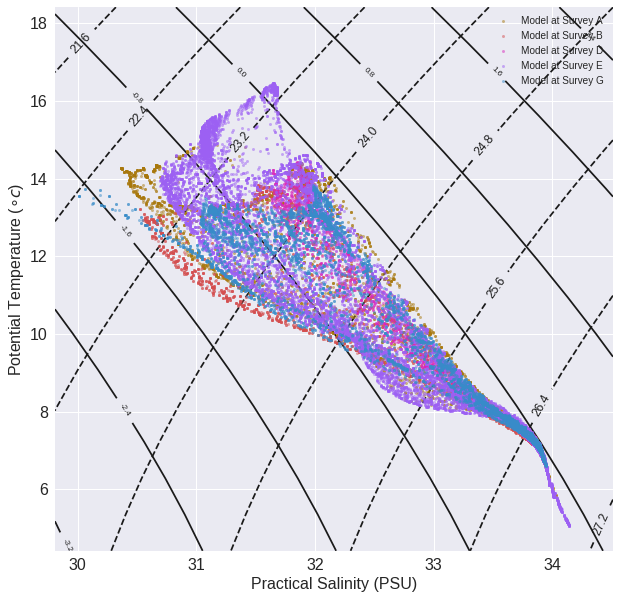

In [86]:
colors = cmo.cm.phase(np.linspace(0, 1, 200))

model_survey_sal_G1 = model_survey_sal_G[model_survey_sal_G>30]
model_survey_temp_G1 = model_survey_temp_G[model_survey_sal_G>30]

# Figure out boudaries (mins and maxs)
smin = np.nanmin(model_survey_sal_G1)  - (0.01 * np.nanmin(model_survey_sal_G1))
smax = np.nanmax(model_survey_sal_E)  + (0.01 * np.nanmax(model_survey_sal_E))
tmin = np.nanmin(model_survey_temp_E) - (0.1 * np.nanmax(model_survey_temp_E))
tmax = np.nanmax(model_survey_temp_E) + (0.1 * np.nanmax(model_survey_temp_E))
 
# Calculate how many gridcells we need in the x and y dimensions
xdim = int(round((smax-smin)/0.1+1,0))
ydim = int(round((tmax-tmin)+1,0))
 
# Create empty grid of zeros
dens_1 = np.empty((ydim,xdim))
spic_1 = np.empty((ydim,xdim))
SA = np.empty((xdim))
CT = np.empty((ydim)) 
# Create temp and salt vectors of appropiate dimensions
ti = np.linspace(1,ydim-1,ydim)+tmin
si = np.linspace(1,xdim-1,xdim)*0.1+smin
 
# Loop to fill in grid with densities
for j in range(0,int(ydim)):
    for i in range(0, int(xdim)):
        
        SA[i] = gsw.SA_from_SP(si[i], 0, lon_gsw, lat_gsw)

        CT[j] = gsw.CT_from_pt(si[i], ti[j])
        
        dens_1[j,i]=gsw.rho(SA[i],CT[j],0)
        
        spic_1[j,i] = gsw.spiciness0(SA[i],CT[j])
 
# Substract 1000 to convert to sigma-t
dens_1 = dens_1 - 1000
 
# Plot data ***********************************************
fig1, ax = plt.subplots(1, 1, figsize=(10,10))
CS = plt.contour(si,ti,dens_1, linestyles='dashed', colors='k')
CS1 = plt.contour(si,ti,spic_1, linestyles='solid', colors='k')
plt.clabel(CS, fontsize=12, inline=1, fmt='%0.1f') # Label every second level
plt.clabel(CS1, fontsize=8, inline=1, fmt='%0.1f') # Label every second level


ax.plot(model_survey_sal_A ,model_survey_temp_A,'o', color= colors[0,:], alpha = 0.5, markersize=3, label='Model at Survey A')

ax.plot(model_survey_sal_B ,model_survey_temp_B, 'o',color= colors[30,:],alpha = 0.5,  markersize=3, label='Model at Survey B')

ax.plot(model_survey_sal_D ,model_survey_temp_D, 'o',color= colors[60,:],alpha = 0.5,  markersize=3, label='Model at Survey D')

ax.plot(model_survey_sal_E ,model_survey_temp_E, 'o',color= colors[90,:], alpha = 0.5, markersize=3, label='Model at Survey E')

ax.plot(model_survey_sal_G1 ,model_survey_temp_G1, 'o',color= colors[120,:], alpha = 0.5, markersize=3, label='Model at Survey G')

# ax.plot(SA_loc_f, CT_loc_f, 'o' ,markersize=9, label = 'Eddy west front')
# ax.set_ylim(5,18)
# ax.set_xlim(30,34)
 
ax.set_xlabel('Practical Salinity (PSU)', fontsize = 16)
ax.set_ylabel('Potential Temperature ($\circ c$)', fontsize = 16)
ax.tick_params(axis='both',labelsize =16)
# ax.set_xlim(31.5,)


legend = ax.legend(loc='upper right', fancybox=True, framealpha=0.25)

In [47]:
smin

-1.7667890676532204e+308

In [36]:
mat = scipy.io.loadmat(survey_mat_file_A)

In [79]:
depths_survey = mat['depths'][:,0]
lat_survey = mat['latitude'][:,0]
lon_survey = mat['longitude'][:,0] - 100
# den_survey = mat['density'][:]
pden_survey = mat['pden'][:]
temp_survey = mat['temp'][:]
sal_survey = mat['salinity'][:]
mtime = mat['mtime'][:,0]

In [6]:
sal_survey.shape

(251, 203)

In [41]:
survey_mat_file_B = '/data/ssahu/Falkor_2013/mvp/surveyB.mat'
mat = scipy.io.loadmat(survey_mat_file_B)

In [60]:
survey_mat_file_D = '/data/ssahu/Falkor_2013/mvp/surveyD.mat'
mat = scipy.io.loadmat(survey_mat_file_D)

In [66]:
survey_mat_file_E = '/data/ssahu/Falkor_2013/mvp/surveyE.mat'
mat = scipy.io.loadmat(survey_mat_file_E)

In [78]:
survey_mat_file_G = '/data/ssahu/Falkor_2013/mvp/surveyG.mat'
mat = scipy.io.loadmat(survey_mat_file_G)

In [13]:
sal_survey.shape

(251, 168)

In [14]:
depths_survey.shape

(251,)

In [16]:
depths_survey[-1]

250.0

In [7]:
file_model = nc.Dataset('/data/ssahu/NEP36_2013_summer_hindcast/cut_NEP36-S29_1d_20130429_20131025_grid_T_20130429-20130508.nc')

lon = file_model.variables['nav_lon'][1:,1:]
lat = file_model.variables['nav_lat'][1:,1:]



lon_gsw = np.mean(lon)
lat_gsw = np.mean(lat)


pressure_survey = np.empty_like(temp_survey)
SA_survey = np.empty_like(temp_survey)
CT_survey = np.empty_like(temp_survey)
spic_survey = np.empty_like(temp_survey)
rho_survey = np.empty_like(temp_survey)

for j in np.arange(depths_survey.shape[0]):

    for i in np.arange(lat_survey.shape[0]):

        pressure_survey[j,i] = gsw.p_from_z(-depths_survey[j],lat_survey[i])

        SA_survey[j,i] = gsw.SA_from_SP(sal_survey[j,i], pressure_survey[j,i], lon_survey[i], lat_survey[i])

        CT_survey[j,i] = gsw.CT_from_pt(sal_survey[j,i], temp_survey[j,i])

        spic_survey[j,i] = gsw.spiciness0(SA_survey[j,i], CT_survey[j,i])

        rho_survey[j,i] = gsw.density.rho(SA_survey[j,i], CT_survey[j,i], 0)


y = np.empty_like(lat_survey)
x = np.empty_like(y)


for i in np.arange(lat_survey.shape[0]):
    y[i], x[i] = geo_tools.find_closest_model_point(
               lon_survey[i],lat_survey[i],lon,lat,tols={
        'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})


In [53]:
temp_survey.shape

(251, 203)

In [81]:
SA_loc_cs = []
CT_loc_cs = []

for i in np.arange(sal_survey.shape[1]):
    SA_loc_cs = np.append(arr=SA_loc_cs, values= sal_survey[:,i][np.isfinite(sal_survey[:,i])])
    CT_loc_cs = np.append(arr=CT_loc_cs, values= temp_survey[:,i][~np.isnan(temp_survey[:,i])])

In [40]:
SA_loc_cs_A = SA_loc_cs
CT_loc_cs_A = CT_loc_cs



In [45]:
SA_loc_cs_B = SA_loc_cs
CT_loc_cs_B = CT_loc_cs

In [64]:
SA_loc_cs_D = SA_loc_cs
CT_loc_cs_D = CT_loc_cs

In [70]:
SA_loc_cs_E = SA_loc_cs
CT_loc_cs_E = CT_loc_cs

In [82]:
SA_loc_cs_G = SA_loc_cs
CT_loc_cs_G = CT_loc_cs

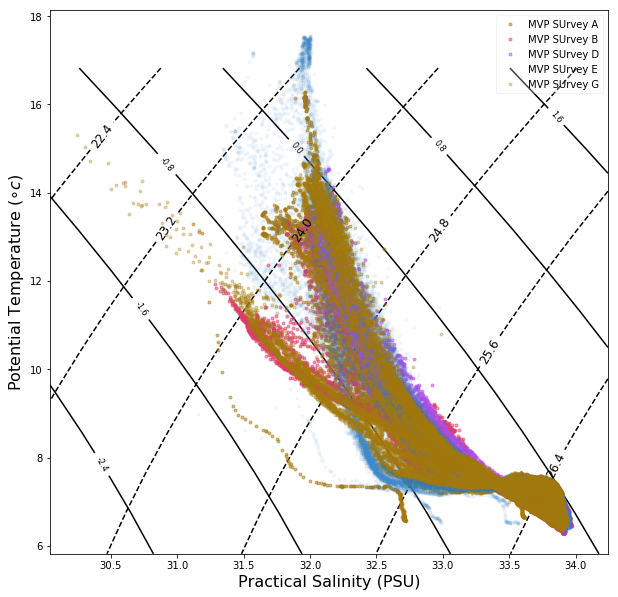

In [84]:
colors = cmo.cm.phase(np.linspace(0, 1, y.shape[0]))

SA_loc_cs_D1 = SA_loc_cs_D[SA_loc_cs_D>30]
CT_loc_cs_D1 = CT_loc_cs_D[SA_loc_cs_D>30]

# Figure out boudaries (mins and maxs)
smin = SA_loc_cs.min() - (0.01 * SA_loc_cs.min())
smax = SA_loc_cs.max() + (0.01 * SA_loc_cs.max())
tmin = CT_loc_cs.min() - (0.1 * CT_loc_cs.max())
tmax = CT_loc_cs.max() + (0.1 * CT_loc_cs.max())
 
# Calculate how many gridcells we need in the x and y dimensions
xdim = int(round((smax-smin)/0.1+1,0))
ydim = int(round((tmax-tmin)+1,0))
 
# Create empty grid of zeros
dens_1 = np.empty((ydim,xdim))
spic_1 = np.empty((ydim,xdim))
SA = np.empty((xdim))
CT = np.empty((ydim)) 
# Create temp and salt vectors of appropiate dimensions
ti = np.linspace(1,ydim-1,ydim)+tmin
si = np.linspace(1,xdim-1,xdim)*0.1+smin
 
# Loop to fill in grid with densities
for j in range(0,int(ydim)):
    for i in range(0, int(xdim)):
        
        SA[i] = gsw.SA_from_SP(si[i], 0, lon_gsw, lat_gsw)

        CT[j] = gsw.CT_from_pt(si[i], ti[j])
        
        dens_1[j,i]=gsw.rho(SA[i],CT[j],0)
        
        spic_1[j,i] = gsw.spiciness0(SA[i],CT[j])
 
# Substract 1000 to convert to sigma-t
dens_1 = dens_1 - 1000
 
# Plot data ***********************************************
fig1, ax = plt.subplots(1, 1, figsize=(10,10))
CS = plt.contour(si,ti,dens_1, linestyles='dashed', colors='k')
CS1 = plt.contour(si,ti,spic_1, linestyles='solid', colors='k')
plt.clabel(CS, fontsize=12, inline=1, fmt='%0.1f') # Label every second level
plt.clabel(CS1, fontsize=8, inline=1, fmt='%0.1f') # Label every second level


ax.plot(SA_loc_cs_A ,CT_loc_cs_A,'o', color= colors[0,:], alpha = 0.5, markersize=3, label='MVP SUrvey A')

ax.plot(SA_loc_cs_B ,CT_loc_cs_B, 'o',color= colors[40,:],alpha = 0.5,  markersize=3, label='MVP SUrvey B')

ax.plot(SA_loc_cs_D1 ,CT_loc_cs_D1, 'o',color= colors[80,:],alpha = 0.5,  markersize=3, label='MVP SUrvey D')

ax.plot(SA_loc_cs_E ,CT_loc_cs_E, 'o',color= colors[120,:], alpha = 0.05, markersize=3, label='MVP SUrvey E')

ax.plot(SA_loc_cs_G ,CT_loc_cs_G, 'o',color= colors[200,:], alpha = 0.3, markersize=3, label='MVP SUrvey G')

# ax.plot(SA_loc_f, CT_loc_f, 'o' ,markersize=9, label = 'Eddy west front')
# ax.set_ylim(5,18)
# ax.set_xlim(30,34)
 
ax.set_xlabel('Practical Salinity (PSU)', fontsize = 16)
ax.set_ylabel('Potential Temperature ($\circ c$)', fontsize = 16)
# ax.set_xlim(31.5,)


legend = ax.legend(loc='upper right', fancybox=True, framealpha=0.25)

In [59]:
SA_loc_cs_D.shape

(15750,)

In [10]:
model_survey_sal  = np.empty((sal.shape[1],y.shape[0],y.shape[0]))
model_survey_temp = np.empty_like(model_survey_sal)
model_survey_rho  = np.empty_like(model_survey_sal)
model_survey_spic = np.empty_like(model_survey_sal)

t = 116


for i in np.arange(y.shape[0]):
    model_survey_sal[:,i,i]   = sal[t,:,y[i],x[i]]
    model_survey_temp[:,i,i]  = temp[t,:,y[i],x[i]]
    model_survey_spic[:,i,i]  = spic[t,:,y[i],x[i]]
    model_survey_rho[:,i,i]   = rho[t,:,y[i],x[i]]

model_survey_temp[model_survey_temp == 0] = np.nan
model_survey_sal[model_survey_sal == 0] = np.nan
model_survey_spic[model_survey_temp == 0] = np.nan

In [77]:
colors = matplotlib.cm.rainbow(np.linspace(0, 1, y.shape[0]))

In [79]:
colors.shape

(203, 4)

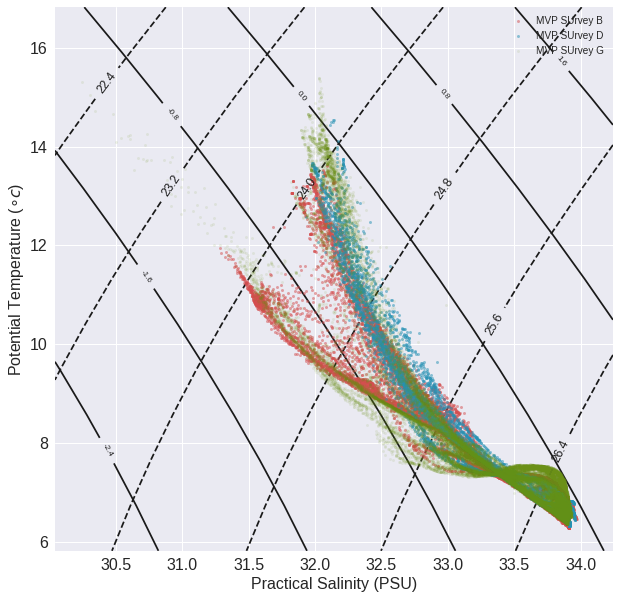

In [87]:
colors = cmo.cm.phase(np.linspace(0, 1, 203))

SA_loc_cs_D1 = SA_loc_cs_D[SA_loc_cs_D>30]
CT_loc_cs_D1 = CT_loc_cs_D[SA_loc_cs_D>30]

# Figure out boudaries (mins and maxs)
smin = SA_loc_cs_G.min() - (0.01 * SA_loc_cs_G.min())
smax = SA_loc_cs_G.max() + (0.01 * SA_loc_cs_G.max())
tmin = CT_loc_cs_G.min() - (0.1 * CT_loc_cs_G.max())
tmax = CT_loc_cs_G.max() + (0.1 * CT_loc_cs_G.max())
 
# Calculate how many gridcells we need in the x and y dimensions
xdim = int(round((smax-smin)/0.1+1,0))
ydim = int(round((tmax-tmin)+1,0))
 
# Create empty grid of zeros
dens_1 = np.empty((ydim,xdim))
spic_1 = np.empty((ydim,xdim))
SA = np.empty((xdim))
CT = np.empty((ydim)) 
# Create temp and salt vectors of appropiate dimensions
ti = np.linspace(1,ydim-1,ydim)+tmin
si = np.linspace(1,xdim-1,xdim)*0.1+smin
 
# Loop to fill in grid with densities
for j in range(0,int(ydim)):
    for i in range(0, int(xdim)):
        
        SA[i] = gsw.SA_from_SP(si[i], 0, lon_gsw, lat_gsw)

        CT[j] = gsw.CT_from_pt(si[i], ti[j])
        
        dens_1[j,i]=gsw.rho(SA[i],CT[j],0)
        
        spic_1[j,i] = gsw.spiciness0(SA[i],CT[j])
 
# Substract 1000 to convert to sigma-t
dens_1 = dens_1 - 1000
 
# Plot data ***********************************************
fig1, ax = plt.subplots(1, 1, figsize=(10,10))
CS = plt.contour(si,ti,dens_1, linestyles='dashed', colors='k')
CS1 = plt.contour(si,ti,spic_1, linestyles='solid', colors='k')
plt.clabel(CS, fontsize=12, inline=1, fmt='%0.1f') # Label every second level
plt.clabel(CS1, fontsize=8, inline=1, fmt='%0.1f') # Label every second level


# ax.plot(SA_loc_cs_A ,CT_loc_cs_A,'o', color= colors[0,:], alpha = 0.5, markersize=3, label='MVP SUrvey A')

ax.plot(SA_loc_cs_B ,CT_loc_cs_B, 'o',color= colors[30,:],alpha = 0.5,  markersize=3, label='MVP SUrvey B')

ax.plot(SA_loc_cs_D1 ,CT_loc_cs_D1, 'o',color= colors[130,:],alpha = 0.5,  markersize=3, label='MVP SUrvey D')

# ax.plot(SA_loc_cs_E ,CT_loc_cs_E, 'o',color= colors[90,:], alpha = 0.5, markersize=3, label='MVP SUrvey E')

ax.plot(SA_loc_cs_G ,CT_loc_cs_G, 'o',color= colors[180,:], alpha = 0.1, markersize=3, label='MVP SUrvey G')

# ax.plot(SA_loc_f, CT_loc_f, 'o' ,markersize=9, label = 'Eddy west front')
# ax.set_ylim(5,18)
# ax.set_xlim(30,34)
 
ax.set_xlabel('Practical Salinity (PSU)', fontsize = 16)
ax.set_ylabel('Potential Temperature ($\circ c$)', fontsize = 16)
ax.tick_params(axis='both',labelsize =16)
# ax.set_xlim(31.5,)


legend = ax.legend(loc='upper right', fancybox=True, framealpha=1)

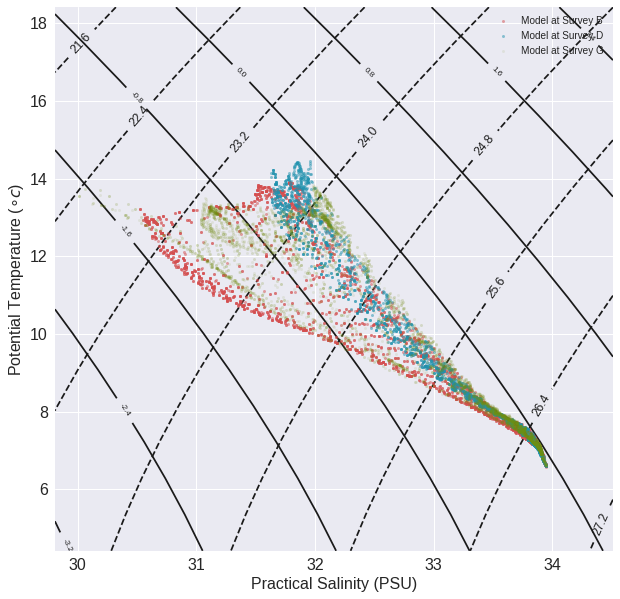

In [88]:
colors = cmo.cm.phase(np.linspace(0, 1, 200))

model_survey_sal_G1 = model_survey_sal_G[model_survey_sal_G>30]
model_survey_temp_G1 = model_survey_temp_G[model_survey_sal_G>30]

# Figure out boudaries (mins and maxs)
smin = np.nanmin(model_survey_sal_G1)  - (0.01 * np.nanmin(model_survey_sal_G1))
smax = np.nanmax(model_survey_sal_E)  + (0.01 * np.nanmax(model_survey_sal_E))
tmin = np.nanmin(model_survey_temp_E) - (0.1 * np.nanmax(model_survey_temp_E))
tmax = np.nanmax(model_survey_temp_E) + (0.1 * np.nanmax(model_survey_temp_E))
 
# Calculate how many gridcells we need in the x and y dimensions
xdim = int(round((smax-smin)/0.1+1,0))
ydim = int(round((tmax-tmin)+1,0))
 
# Create empty grid of zeros
dens_1 = np.empty((ydim,xdim))
spic_1 = np.empty((ydim,xdim))
SA = np.empty((xdim))
CT = np.empty((ydim)) 
# Create temp and salt vectors of appropiate dimensions
ti = np.linspace(1,ydim-1,ydim)+tmin
si = np.linspace(1,xdim-1,xdim)*0.1+smin
 
# Loop to fill in grid with densities
for j in range(0,int(ydim)):
    for i in range(0, int(xdim)):
        
        SA[i] = gsw.SA_from_SP(si[i], 0, lon_gsw, lat_gsw)

        CT[j] = gsw.CT_from_pt(si[i], ti[j])
        
        dens_1[j,i]=gsw.rho(SA[i],CT[j],0)
        
        spic_1[j,i] = gsw.spiciness0(SA[i],CT[j])
 
# Substract 1000 to convert to sigma-t
dens_1 = dens_1 - 1000
 
# Plot data ***********************************************
fig1, ax = plt.subplots(1, 1, figsize=(10,10))
CS = plt.contour(si,ti,dens_1, linestyles='dashed', colors='k')
CS1 = plt.contour(si,ti,spic_1, linestyles='solid', colors='k')
plt.clabel(CS, fontsize=12, inline=1, fmt='%0.1f') # Label every second level
plt.clabel(CS1, fontsize=8, inline=1, fmt='%0.1f') # Label every second level


# ax.plot(model_survey_sal_A ,model_survey_temp_A,'o', color= colors[0,:], alpha = 0.5, markersize=3, label='Model at Survey A')

ax.plot(model_survey_sal_B ,model_survey_temp_B, 'o',color= colors[30,:],alpha = 0.5,  markersize=3, label='Model at Survey B')

ax.plot(model_survey_sal_D ,model_survey_temp_D, 'o',color= colors[130,:],alpha = 0.5,  markersize=3, label='Model at Survey D')

# ax.plot(model_survey_sal_E ,model_survey_temp_E, 'o',color= colors[90,:], alpha = 0.5, markersize=3, label='Model at Survey E')

ax.plot(model_survey_sal_G1 ,model_survey_temp_G1, 'o',color= colors[180,:], alpha = 0.1, markersize=3, label='Model at Survey G')

# ax.plot(SA_loc_f, CT_loc_f, 'o' ,markersize=9, label = 'Eddy west front')
# ax.set_ylim(5,18)
# ax.set_xlim(30,34)
 
ax.set_xlabel('Practical Salinity (PSU)', fontsize = 16)
ax.set_ylabel('Potential Temperature ($\circ c$)', fontsize = 16)
ax.tick_params(axis='both',labelsize =16)
# ax.set_xlim(31.5,)


legend = ax.legend(loc='upper right', fancybox=True, framealpha=0.25)

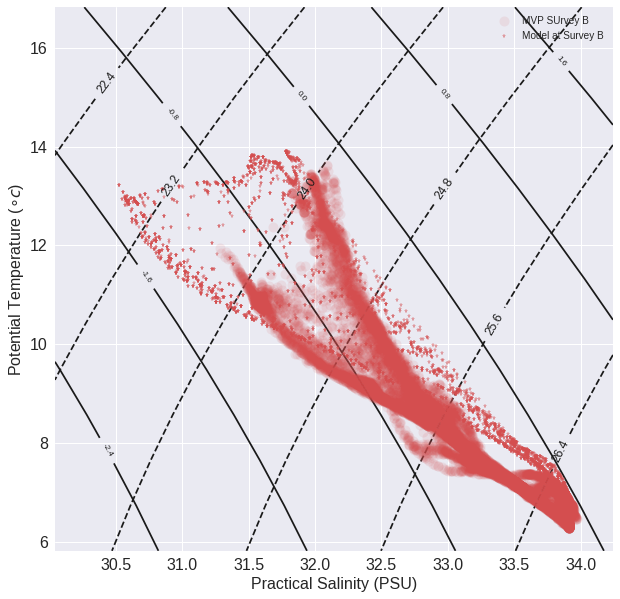

In [89]:
colors = cmo.cm.phase(np.linspace(0, 1, 203))

SA_loc_cs_D1 = SA_loc_cs_D[SA_loc_cs_D>30]
CT_loc_cs_D1 = CT_loc_cs_D[SA_loc_cs_D>30]

# Figure out boudaries (mins and maxs)
smin = SA_loc_cs_G.min() - (0.01 * SA_loc_cs_G.min())
smax = SA_loc_cs_G.max() + (0.01 * SA_loc_cs_G.max())
tmin = CT_loc_cs_G.min() - (0.1 * CT_loc_cs_G.max())
tmax = CT_loc_cs_G.max() + (0.1 * CT_loc_cs_G.max())
 
# Calculate how many gridcells we need in the x and y dimensions
xdim = int(round((smax-smin)/0.1+1,0))
ydim = int(round((tmax-tmin)+1,0))
 
# Create empty grid of zeros
dens_1 = np.empty((ydim,xdim))
spic_1 = np.empty((ydim,xdim))
SA = np.empty((xdim))
CT = np.empty((ydim)) 
# Create temp and salt vectors of appropiate dimensions
ti = np.linspace(1,ydim-1,ydim)+tmin
si = np.linspace(1,xdim-1,xdim)*0.1+smin
 
# Loop to fill in grid with densities
for j in range(0,int(ydim)):
    for i in range(0, int(xdim)):
        
        SA[i] = gsw.SA_from_SP(si[i], 0, lon_gsw, lat_gsw)

        CT[j] = gsw.CT_from_pt(si[i], ti[j])
        
        dens_1[j,i]=gsw.rho(SA[i],CT[j],0)
        
        spic_1[j,i] = gsw.spiciness0(SA[i],CT[j])
 
# Substract 1000 to convert to sigma-t
dens_1 = dens_1 - 1000
 
# Plot data ***********************************************
fig1, ax = plt.subplots(1, 1, figsize=(10,10))
CS = plt.contour(si,ti,dens_1, linestyles='dashed', colors='k')
CS1 = plt.contour(si,ti,spic_1, linestyles='solid', colors='k')
plt.clabel(CS, fontsize=12, inline=1, fmt='%0.1f') # Label every second level
plt.clabel(CS1, fontsize=8, inline=1, fmt='%0.1f') # Label every second level


# ax.plot(SA_loc_cs_A ,CT_loc_cs_A,'o', color= colors[0,:], alpha = 0.5, markersize=3, label='MVP SUrvey A')

ax.plot(SA_loc_cs_B ,CT_loc_cs_B, 'o',color= colors[30,:],alpha = 0.1,  markersize=10, label='MVP SUrvey B')

# ax.plot(SA_loc_cs_D1 ,CT_loc_cs_D1, 'o',color= colors[130,:],alpha = 0.5,  markersize=5, label='MVP SUrvey D')

# ax.plot(SA_loc_cs_E ,CT_loc_cs_E, 'o',color= colors[90,:], alpha = 0.5, markersize=3, label='MVP SUrvey E')

# ax.plot(SA_loc_cs_G ,CT_loc_cs_G, 'o',color= colors[180,:], alpha = 0.1, markersize=5, label='MVP SUrvey G')



ax.plot(model_survey_sal_B ,model_survey_temp_B, '*',color= colors[30,:],alpha = 0.5,  markersize=5, label='Model at Survey B')

# ax.plot(model_survey_sal_D ,model_survey_temp_D, '*',color= colors[130,:],alpha = 0.5,  markersize=5, label='Model at Survey D')

# ax.plot(model_survey_sal_E ,model_survey_temp_E, 'o',color= colors[90,:], alpha = 0.5, markersize=3, label='Model at Survey E')

# ax.plot(model_survey_sal_G1 ,model_survey_temp_G1, '*',color= colors[180,:], alpha = 0.1, markersize=5, label='Model at Survey G')

# ax.plot(SA_loc_f, CT_loc_f, 'o' ,markersize=9, label = 'Eddy west front')
# ax.set_ylim(5,18)
# ax.set_xlim(30,34)
 
ax.set_xlabel('Practical Salinity (PSU)', fontsize = 16)
ax.set_ylabel('Potential Temperature ($\circ c$)', fontsize = 16)
ax.tick_params(axis='both',labelsize =16)
# ax.set_xlim(31.5,)


legend = ax.legend(loc='upper right', fancybox=True, framealpha=1)

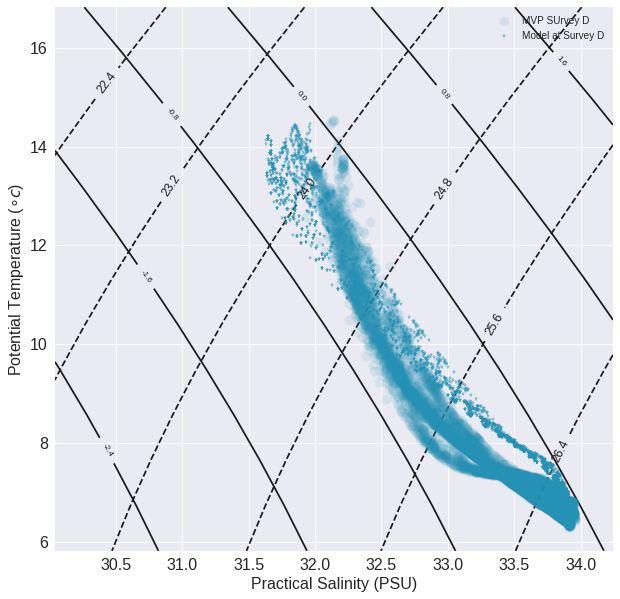

In [90]:
colors = cmo.cm.phase(np.linspace(0, 1, 203))

SA_loc_cs_D1 = SA_loc_cs_D[SA_loc_cs_D>30]
CT_loc_cs_D1 = CT_loc_cs_D[SA_loc_cs_D>30]

# Figure out boudaries (mins and maxs)
smin = SA_loc_cs_G.min() - (0.01 * SA_loc_cs_G.min())
smax = SA_loc_cs_G.max() + (0.01 * SA_loc_cs_G.max())
tmin = CT_loc_cs_G.min() - (0.1 * CT_loc_cs_G.max())
tmax = CT_loc_cs_G.max() + (0.1 * CT_loc_cs_G.max())
 
# Calculate how many gridcells we need in the x and y dimensions
xdim = int(round((smax-smin)/0.1+1,0))
ydim = int(round((tmax-tmin)+1,0))
 
# Create empty grid of zeros
dens_1 = np.empty((ydim,xdim))
spic_1 = np.empty((ydim,xdim))
SA = np.empty((xdim))
CT = np.empty((ydim)) 
# Create temp and salt vectors of appropiate dimensions
ti = np.linspace(1,ydim-1,ydim)+tmin
si = np.linspace(1,xdim-1,xdim)*0.1+smin
 
# Loop to fill in grid with densities
for j in range(0,int(ydim)):
    for i in range(0, int(xdim)):
        
        SA[i] = gsw.SA_from_SP(si[i], 0, lon_gsw, lat_gsw)

        CT[j] = gsw.CT_from_pt(si[i], ti[j])
        
        dens_1[j,i]=gsw.rho(SA[i],CT[j],0)
        
        spic_1[j,i] = gsw.spiciness0(SA[i],CT[j])
 
# Substract 1000 to convert to sigma-t
dens_1 = dens_1 - 1000
 
# Plot data ***********************************************
fig1, ax = plt.subplots(1, 1, figsize=(10,10))
CS = plt.contour(si,ti,dens_1, linestyles='dashed', colors='k')
CS1 = plt.contour(si,ti,spic_1, linestyles='solid', colors='k')
plt.clabel(CS, fontsize=12, inline=1, fmt='%0.1f') # Label every second level
plt.clabel(CS1, fontsize=8, inline=1, fmt='%0.1f') # Label every second level


# ax.plot(SA_loc_cs_A ,CT_loc_cs_A,'o', color= colors[0,:], alpha = 0.5, markersize=3, label='MVP SUrvey A')

# ax.plot(SA_loc_cs_B ,CT_loc_cs_B, 'o',color= colors[30,:],alpha = 0.1,  markersize=10, label='MVP SUrvey B')

ax.plot(SA_loc_cs_D1 ,CT_loc_cs_D1, 'o',color= colors[130,:],alpha = 0.1,  markersize=10, label='MVP SUrvey D')

# ax.plot(SA_loc_cs_E ,CT_loc_cs_E, 'o',color= colors[90,:], alpha = 0.5, markersize=3, label='MVP SUrvey E')

# ax.plot(SA_loc_cs_G ,CT_loc_cs_G, 'o',color= colors[180,:], alpha = 0.1, markersize=5, label='MVP SUrvey G')



# ax.plot(model_survey_sal_B ,model_survey_temp_B, '*',color= colors[30,:],alpha = 0.5,  markersize=5, label='Model at Survey B')

ax.plot(model_survey_sal_D ,model_survey_temp_D, '*',color= colors[130,:],alpha = 0.5,  markersize=5, label='Model at Survey D')

# ax.plot(model_survey_sal_E ,model_survey_temp_E, 'o',color= colors[90,:], alpha = 0.5, markersize=3, label='Model at Survey E')

# ax.plot(model_survey_sal_G1 ,model_survey_temp_G1, '*',color= colors[180,:], alpha = 0.1, markersize=5, label='Model at Survey G')

# ax.plot(SA_loc_f, CT_loc_f, 'o' ,markersize=9, label = 'Eddy west front')
# ax.set_ylim(5,18)
# ax.set_xlim(30,34)
 
ax.set_xlabel('Practical Salinity (PSU)', fontsize = 16)
ax.set_ylabel('Potential Temperature ($\circ c$)', fontsize = 16)
ax.tick_params(axis='both',labelsize =16)
# ax.set_xlim(31.5,)


legend = ax.legend(loc='upper right', fancybox=True, framealpha=1)

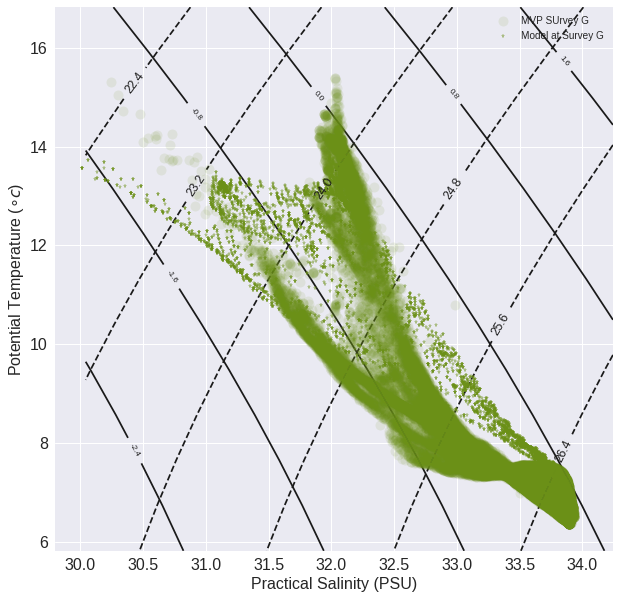

In [10]:
colors = cmo.cm.phase(np.linspace(0, 1, 203))

SA_loc_cs_D1 = SA_loc_cs_D[SA_loc_cs_D>30]
CT_loc_cs_D1 = CT_loc_cs_D[SA_loc_cs_D>30]

# Figure out boudaries (mins and maxs)
smin = SA_loc_cs_G.min() - (0.01 * SA_loc_cs_G.min())
smax = SA_loc_cs_G.max() + (0.01 * SA_loc_cs_G.max())
tmin = CT_loc_cs_G.min() - (0.1 * CT_loc_cs_G.max())
tmax = CT_loc_cs_G.max() + (0.1 * CT_loc_cs_G.max())
 
# Calculate how many gridcells we need in the x and y dimensions
xdim = int(round((smax-smin)/0.1+1,0))
ydim = int(round((tmax-tmin)+1,0))
 
# Create empty grid of zeros
dens_1 = np.empty((ydim,xdim))
spic_1 = np.empty((ydim,xdim))
SA = np.empty((xdim))
CT = np.empty((ydim)) 
# Create temp and salt vectors of appropiate dimensions
ti = np.linspace(1,ydim-1,ydim)+tmin
si = np.linspace(1,xdim-1,xdim)*0.1+smin
 
# Loop to fill in grid with densities
for j in range(0,int(ydim)):
    for i in range(0, int(xdim)):
        
        SA[i] = gsw.SA_from_SP(si[i], 0, lon_gsw, lat_gsw)

        CT[j] = gsw.CT_from_pt(si[i], ti[j])
        
        dens_1[j,i]=gsw.rho(SA[i],CT[j],0)
        
        spic_1[j,i] = gsw.spiciness0(SA[i],CT[j])
 
# Substract 1000 to convert to sigma-t
dens_1 = dens_1 - 1000
 
# Plot data ***********************************************
fig1, ax = plt.subplots(1, 1, figsize=(10,10))
CS = plt.contour(si,ti,dens_1, linestyles='dashed', colors='k')
CS1 = plt.contour(si,ti,spic_1, linestyles='solid', colors='k')
plt.clabel(CS, fontsize=12, inline=1, fmt='%0.1f') # Label every second level
plt.clabel(CS1, fontsize=8, inline=1, fmt='%0.1f') # Label every second level


# ax.plot(SA_loc_cs_A ,CT_loc_cs_A,'o', color= colors[0,:], alpha = 0.5, markersize=3, label='MVP SUrvey A')

# ax.plot(SA_loc_cs_B ,CT_loc_cs_B, 'o',color= colors[30,:],alpha = 0.1,  markersize=10, label='MVP SUrvey B')

# ax.plot(SA_loc_cs_D1 ,CT_loc_cs_D1, 'o',color= colors[130,:],alpha = 0.1,  markersize=10, label='MVP SUrvey D')

# ax.plot(SA_loc_cs_E ,CT_loc_cs_E, 'o',color= colors[90,:], alpha = 0.5, markersize=3, label='MVP SUrvey E')

ax.plot(SA_loc_cs_G ,CT_loc_cs_G, 'o',color= colors[180,:], alpha = 0.1, markersize=10, label='MVP SUrvey G')



# ax.plot(model_survey_sal_B ,model_survey_temp_B, '*',color= colors[30,:],alpha = 0.5,  markersize=5, label='Model at Survey B')

# ax.plot(model_survey_sal_D ,model_survey_temp_D, '*',color= colors[130,:],alpha = 0.5,  markersize=5, label='Model at Survey D')

# ax.plot(model_survey_sal_E ,model_survey_temp_E, 'o',color= colors[90,:], alpha = 0.5, markersize=3, label='Model at Survey E')

ax.plot(model_survey_sal_G1 ,model_survey_temp_G1, '*',color= colors[180,:], alpha = 0.5, markersize=5, label='Model at Survey G')

# ax.plot(SA_loc_f, CT_loc_f, 'o' ,markersize=9, label = 'Eddy west front')
# ax.set_ylim(5,18)
# ax.set_xlim(30,34)
 
ax.set_xlabel('Practical Salinity (PSU)', fontsize = 16)
ax.set_ylabel('Potential Temperature ($\circ c$)', fontsize = 16)
ax.tick_params(axis='both',labelsize =16)
# ax.set_xlim(31.5,)


legend = ax.legend(loc='upper right', fancybox=True, framealpha=1)

In [139]:
file = survey_file_B

In [140]:
mat = scipy.io.loadmat(file)

depths_survey = mat['depths'][:,0]
lat_survey = mat['latitude'][:,0]
lon_survey = mat['longitude'][:,0] - 100
# den_survey = mat['density'][:]
pden_survey = mat['pden'][:]
temp_survey = mat['temp'][:]
sal_survey = mat['salinity'][:]
mtime = mat['mtime'][:,0]

In [141]:
depths_survey.shape

(251,)

In [142]:
temp_survey.shape

(251, 168)

In [143]:
y = np.empty_like(temp_survey)

max_depths = np.empty((temp_survey.shape[1]))

y[:,:] = np.isnan(temp_survey)

for i in np.arange(max_depths.shape[0]):
    if (np.isfinite(temp_survey[:,i])).any() == True:
        max_depths[i] = np.max(depths_survey[np.isfinite(temp_survey[:,i])])

In [144]:
lon_max_depth = lon_survey[np.where(max_depths == np.max(max_depths))]
lat_max_depth = lat_survey[np.where(max_depths == np.max(max_depths))]
p_den_max_depth = pden_survey[:,np.where(max_depths == np.max(max_depths))]
p_den_max_depth = p_den_max_depth[:,0,:]
temp_den_max_depth = temp_survey[:,np.where(max_depths == np.max(max_depths))]
temp_den_max_depth = temp_den_max_depth[:,0,:]
sal_den_max_depth = sal_survey[:,np.where(max_depths == np.max(max_depths))]
sal_den_max_depth = sal_den_max_depth[:,0,:]



q = np.empty_like(lon_max_depth)
p = np.empty_like(q)

In [145]:
for i in np.arange(lat_max_depth.shape[0]):
    q[i], p[i] = geo_tools.find_closest_model_point(
               lon_max_depth[i],lat_max_depth[i],lon,lat,tols={
        'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})

In [10]:
bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

mbathy = mask.variables['mbathy'][0,180:350, 480:650]
Z = bathy.variables['Bathymetry'][180:350, 480:650]

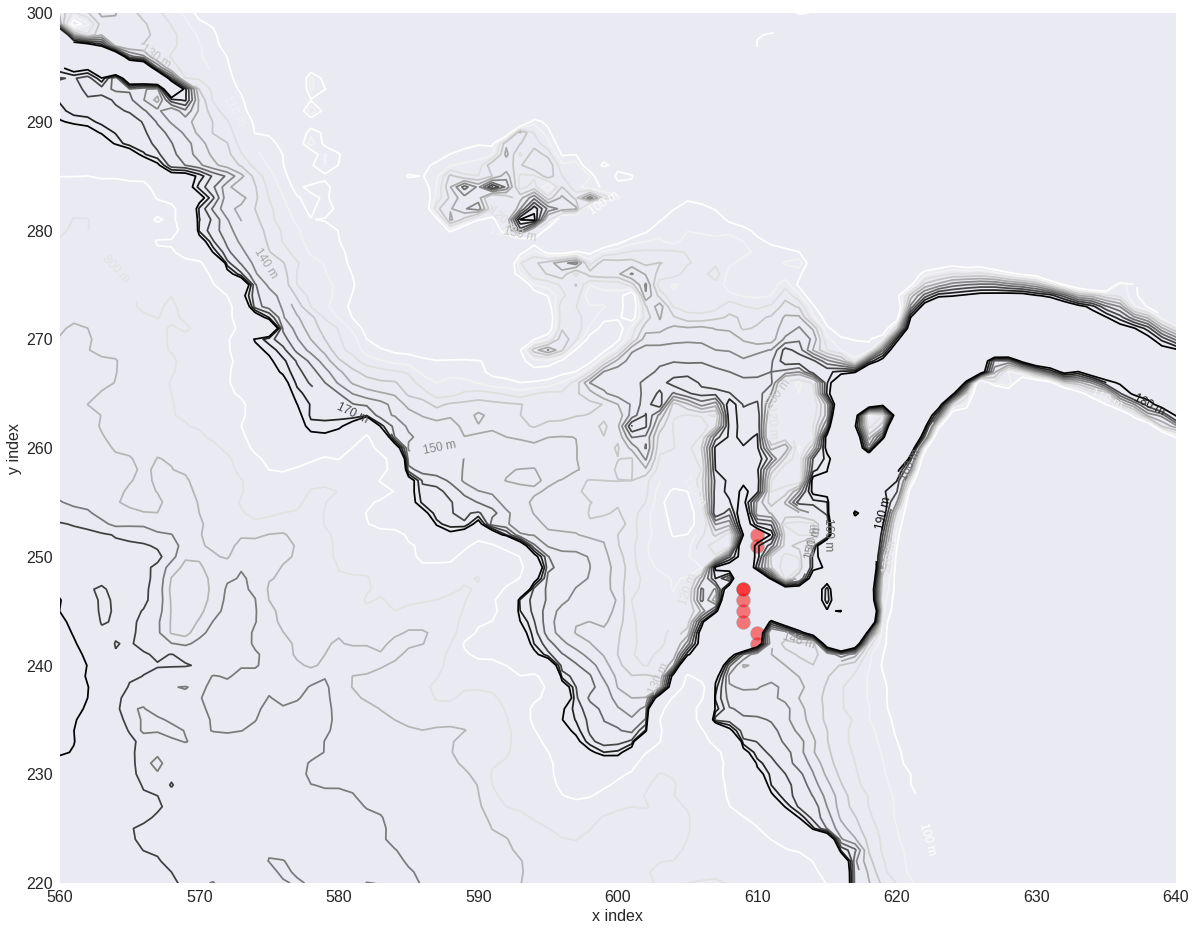

In [147]:
colors = cmo.cm.phase(np.linspace(0, 1, p.shape[0]))
# # plt.style.use('default')

# sns.set_context('paper')
# sns.set_color_codes()
# plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}
# plt.style.use('seaborn')

cmap = cmo.cm.deep
#     cmap.set_bad('burlywood')
cmap.set_bad('#8b7765')

fig, ax = plt.subplots(1, 1, figsize=(20,16)); ax.grid()
#     ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=np.mean(lon)))
CS = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[:,:], np.arange(100,200,10))
CS1 = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[:,:], level = [0,500,1000], color = 'k' )
CLS = plt.clabel(CS, inline=3,fmt='%0.0f m', fontsize=12)
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)




for i in np.arange(p.shape[0]):

    ax.scatter(x_wcvi_slice[np.int(p[i])], y_wcvi_slice[np.int(q[i])], c = 'Red', cmap = cmap, s=200, alpha=0.5, edgecolor= 'cyan' )


ax.set_ylim(220,300)
ax.set_xlim(560,640)
    
ax.set_xlabel('x index', fontsize =16)
ax.set_ylabel('y index', fontsize = 16)
ax.tick_params(axis='both',labelsize =16)


In [148]:
pressure = np.empty_like(sal_den_max_depth)
SA = np.empty_like(pressure)
CT = np.empty_like(SA)
spic_max_depth = np.empty_like(SA)
N_MVP = np.empty_like(SA)
pmid = np.empty_like(N_MVP)
Z_N_MVP = np.empty((pmid.shape[0]-1))


for j in np.arange(depths_survey.shape[0]):

    for i in np.arange(p.shape[0]):

        pressure[j,i] = gsw.p_from_z(-depths_survey[j],lat_max_depth[i])

        SA[j,i] = gsw.SA_from_SP(sal_den_max_depth[j,i], pressure[j,i], lon_max_depth[i], lat_max_depth[i])

        CT[j,i] = gsw.CT_from_pt(sal_den_max_depth[j,i], temp_den_max_depth[j,i])

        spic_max_depth[j,i] = gsw.spiciness0(SA[j,i], CT[j,i])
        
        
for i in np.arange(p.shape[0]): 
    N_MVP[1:,i],pmid[1:,i] = gsw.stability.Nsquared(SA[:,i], CT[:,i], pressure[:,i], lat_max_depth[0])
    
Z_N_MVP[:] = -gsw.z_from_p(pmid[1:,0], lat_max_depth[0])

In [149]:
model_maxdepth_sal = np.empty((sal.shape[1],q.shape[0]))
model_maxdepth_temp = np.empty_like(model_maxdepth_sal)
model_maxdepth_rho = np.empty_like(model_maxdepth_sal)
model_maxdepth_spic = np.empty_like(model_maxdepth_sal)

t = 116



for i in np.arange(p.shape[0]):
    model_maxdepth_sal[:,i]   = sal[t,:,q[i],p[i]]
    model_maxdepth_temp[:,i]  = temp[t,:,q[i],p[i]]
    model_maxdepth_spic[:,i]  = spic[t,:,q[i],p[i]]
    model_maxdepth_rho[:,i]   = rho[t,:,q[i],p[i]]
    


pressure_model = np.empty_like(model_maxdepth_sal)
SA_model = np.empty_like(pressure_model)
CT_model = np.empty_like(SA_model)
N_model = np.empty_like(SA_model)
pmid_model = np.empty_like(N_model)
Z_N_model = np.empty((pmid_model.shape[0]-1))
    
for j in np.arange(model_maxdepth_sal.shape[0]):

    for i in np.arange(model_maxdepth_sal.shape[1]):

        pressure_model[j,i] = gsw.p_from_z(-zlevels[j],lat_max_depth[0])

        SA_model[j,i] = gsw.SA_from_SP(model_maxdepth_sal[j,i], pressure_model[j,i], lon_max_depth[i], lat_max_depth[i])

        CT_model[j,i] = gsw.CT_from_pt(model_maxdepth_sal[j,i], model_maxdepth_temp[j,i])
    

for i in np.arange(p.shape[0]): 
    N_model[1:,i],pmid_model[1:,i] = gsw.stability.Nsquared(SA_model[:,i], CT_model[:,i], pressure_model[:,i], lat_max_depth[0])
    
Z_N_model[:] = -gsw.z_from_p(pmid_model[1:,0], lat_max_depth[0])

In [150]:
model_maxdepth_sal.shape

(32, 9)

At shelf break depth inside the Tully Canyon


(-0.5, 0.1)

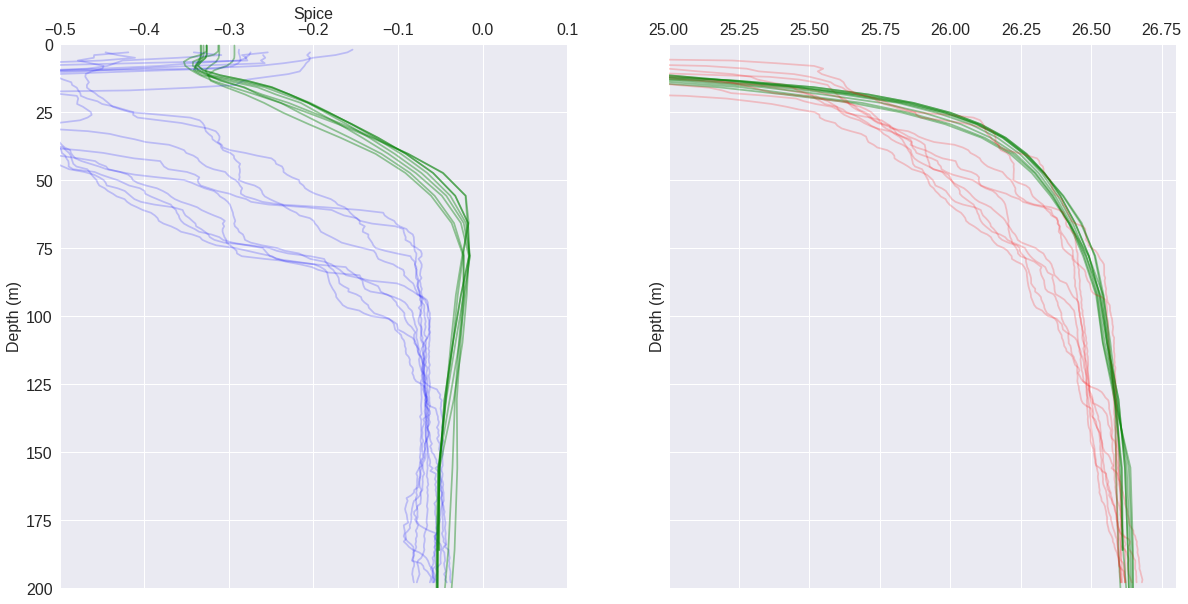

In [151]:
print("At shelf break depth inside the Tully Canyon")
model_maxdepth_spic[model_maxdepth_spic < -10] = np.nan
model_maxdepth_rho[model_maxdepth_rho - 1000 < 0] = np.nan

# fig2, (ax2, ax3, ax4) = plt.subplots(1,3,sharey=True,figsize=(15,8))

fig2, (ax1,ax2) = plt.subplots(1,2,sharey=True,figsize=(20,10))
# Temperature
for i in np.arange(p.shape[0]):
#     ax2.plot(model_survey_sal[:,i,i],zlevels[:], c = colors[i,:])
    ax2.plot(p_den_max_depth[:,i]-1000 ,depths_survey[:],  c = 'red', alpha = 0.2, label = 'MVP')
    ax2.plot(model_maxdepth_rho[:,i]-1000, zlevels[:], c = 'green', alpha = 0.4, label = 'NEP36')
    
ax2.set_ylabel('Depth (m)', fontsize = 16)
ax2.set_ylim(0,200)
ax2.set_ylim(ax2.get_ylim()[::-1]) 
# ax2.set_xlabel('Density', fontsize = 16)
ax2.xaxis.set_label_position('top') 
ax2.xaxis.set_ticks_position('top') 
ax2.tick_params(axis='both',labelsize =16)
ax2.set_xlim(25,26.8)


for i in np.arange(p.shape[0]):
#     ax2.plot(model_survey_sal[:,i,i],zlevels[:], c = colors[i,:])
    ax1.plot(spic_max_depth[:,i] ,depths_survey[:], c = 'blue', alpha = 0.2, label = 'MVP')
    ax1.plot(model_maxdepth_spic[:,i], zlevels[:], c = 'green', alpha = 0.4, label = 'NEP36')
    
ax1.set_ylabel('Depth (m)', fontsize = 16)
ax1.set_ylim(0,200)
ax1.set_ylim(ax2.get_ylim()[::-1]) 
ax1.set_xlabel('Spice', fontsize = 16)
ax1.xaxis.set_label_position('top') 
ax1.xaxis.set_ticks_position('top') 
ax1.tick_params(axis='both',labelsize =16)
ax1.set_xlim(-0.5,0.1)


N at shelf break depth inside the Tully Canyon


/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()


(-0.0001, 0.0025)

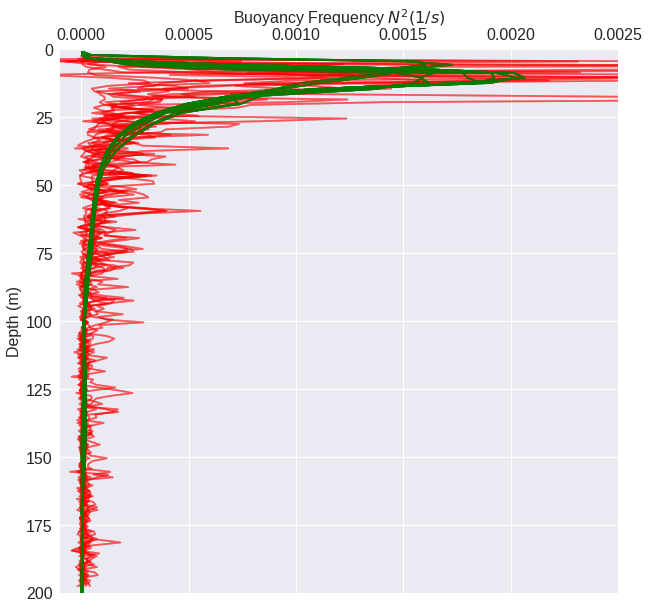

In [153]:
print("N at shelf break depth inside the Tully Canyon")

N_model[N_model < -0.005] = np.nan

fig2, ax2 = plt.subplots(1,1,figsize=(10,10))
# Temperature
for i in np.arange(p.shape[0]):
    ax2.plot(N_MVP[1:,:] ,Z_N_MVP[:],  c = 'red', alpha = 0.1, label = 'MVP')
    ax2.plot(N_model[1:,:] ,Z_N_model[:], c = 'green', alpha = 0.4, label = 'NEP36')
    
ax2.set_ylabel('Depth (m)', fontsize = 16)
ax2.set_ylim(0,200)
ax2.set_ylim(ax2.get_ylim()[::-1]) 
ax2.set_xlabel('Buoyancy Frequency $N^2 (1/s)$', fontsize = 16)
ax2.xaxis.set_label_position('top') 
ax2.xaxis.set_ticks_position('top') 
ax2.tick_params(axis='both',labelsize =16)
ax2.set_xlim(-0.0001,0.0025)

In [78]:
file = survey_file_A

In [79]:
mat = scipy.io.loadmat(file)

depths_survey = mat['depths'][:,0]
lat_survey = mat['latitude'][:,0]
lon_survey = mat['longitude'][:,0] - 100
# den_survey = mat['density'][:]
pden_survey = mat['pden'][:]
temp_survey = mat['temp'][:]
sal_survey = mat['salinity'][:]
mtime = mat['mtime'][:,0]

In [80]:
y = np.empty_like(temp_survey)

max_depths = np.empty((temp_survey.shape[1]))

y[:,:] = np.isnan(temp_survey)

for i in np.arange(max_depths.shape[0]):
    if (np.isfinite(temp_survey[:,i])).any() == True:
        max_depths[i] = np.max(depths_survey[np.isfinite(temp_survey[:,i])])

In [119]:
lon_max_depth = lon_survey[np.where(max_depths == np.max(max_depths))]
lat_max_depth = lat_survey[np.where(max_depths == np.max(max_depths))]
p_den_max_depth = pden_survey[:,np.where(max_depths == np.max(max_depths))]
p_den_max_depth = p_den_max_depth[:,0,:]
temp_den_max_depth = temp_survey[:,np.where(max_depths == np.max(max_depths))]
temp_den_max_depth = temp_den_max_depth[:,0,:]
sal_den_max_depth = sal_survey[:,np.where(max_depths == np.max(max_depths))]
sal_den_max_depth = sal_den_max_depth[:,0,:]



q = np.empty_like(lon_max_depth)
p = np.empty_like(q)

In [120]:
for i in np.arange(lat_max_depth.shape[0]):
    q[i], p[i] = geo_tools.find_closest_model_point(
               lon_max_depth[i],lat_max_depth[i],lon,lat,tols={
        'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})

In [121]:
bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

mbathy = mask.variables['mbathy'][0,180:350, 480:650]
Z = bathy.variables['Bathymetry'][180:350, 480:650]

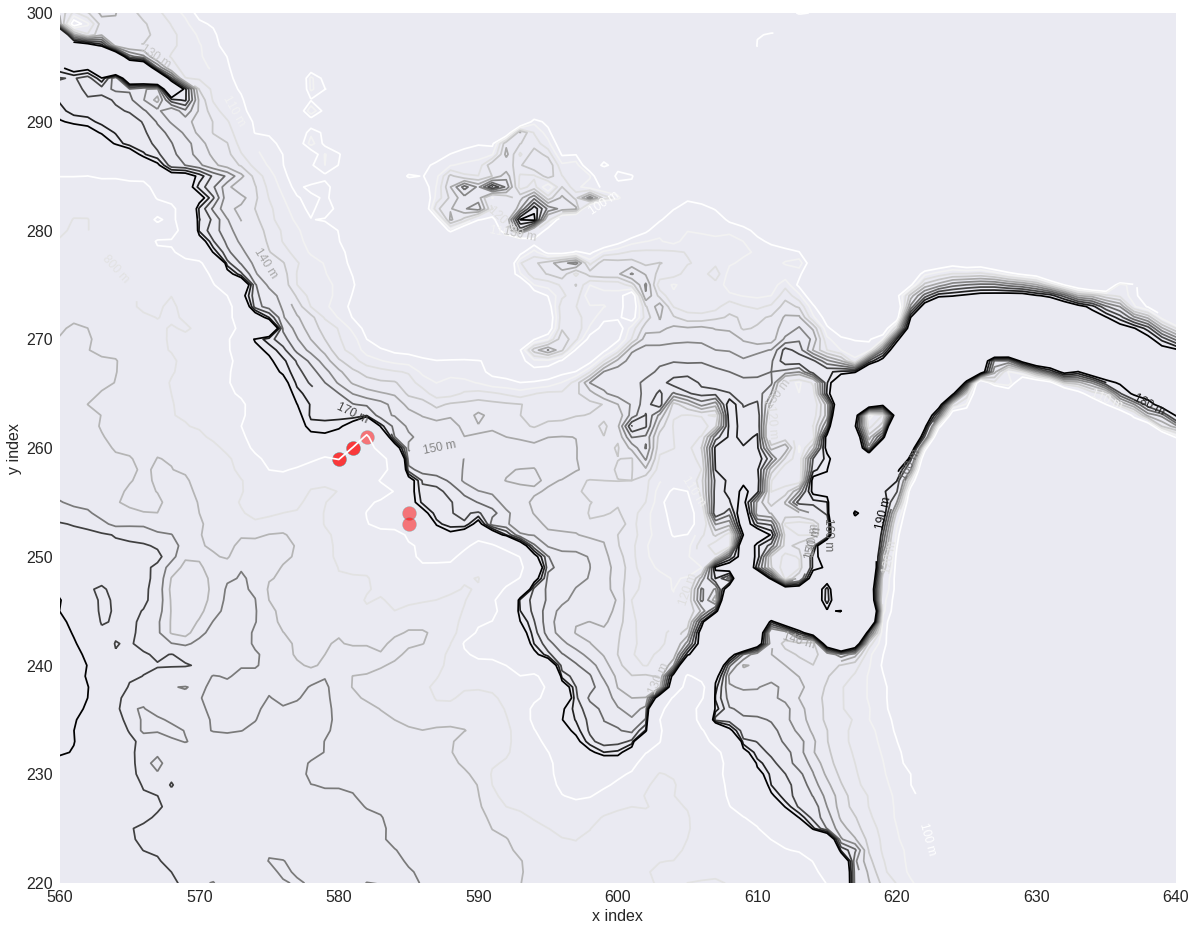

In [122]:
colors = cmo.cm.phase(np.linspace(0, 1, p.shape[0]))
# # plt.style.use('default')

# sns.set_context('paper')
# sns.set_color_codes()
# plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}
# plt.style.use('seaborn')

cmap = cmo.cm.deep
#     cmap.set_bad('burlywood')
cmap.set_bad('#8b7765')

fig, ax = plt.subplots(1, 1, figsize=(20,16)); ax.grid()
#     ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=np.mean(lon)))
CS = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[:,:], np.arange(100,200,10))
CS1 = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[:,:], level = [0,500,1000], color = 'k' )
CLS = plt.clabel(CS, inline=3,fmt='%0.0f m', fontsize=12)
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)




for i in np.arange(p.shape[0]):

    ax.scatter(x_wcvi_slice[np.int(p[i])], y_wcvi_slice[np.int(q[i])], c = 'Red', cmap = cmap, s=200, alpha=0.5, edgecolor= 'cyan' )


ax.set_ylim(220,300)
ax.set_xlim(560,640)
    
ax.set_xlabel('x index', fontsize =16)
ax.set_ylabel('y index', fontsize = 16)
ax.tick_params(axis='both',labelsize =16)


In [123]:
pressure = np.empty_like(sal_den_max_depth)
SA = np.empty_like(pressure)
CT = np.empty_like(SA)
spic_max_depth = np.empty_like(SA)
N_MVP = np.empty_like(SA)
pmid = np.empty_like(N_MVP)
Z_N_MVP = np.empty((pmid.shape[0]-1))


for j in np.arange(depths_survey.shape[0]):

    for i in np.arange(p.shape[0]):

        pressure[j,i] = gsw.p_from_z(-depths_survey[j],lat_max_depth[i])

        SA[j,i] = gsw.SA_from_SP(sal_den_max_depth[j,i], pressure[j,i], lon_max_depth[i], lat_max_depth[i])

        CT[j,i] = gsw.CT_from_pt(sal_den_max_depth[j,i], temp_den_max_depth[j,i])

        spic_max_depth[j,i] = gsw.spiciness0(SA[j,i], CT[j,i])
        
        
for i in np.arange(p.shape[0]): 
    N_MVP[1:,i],pmid[1:,i] = gsw.stability.Nsquared(SA[:,i], CT[:,i], pressure[:,i], lat_max_depth[0])
    
Z_N_MVP[:] = -gsw.z_from_p(pmid[1:,0], lat_max_depth[0])

model_maxdepth_sal = np.empty((sal.shape[1],q.shape[0]))
model_maxdepth_temp = np.empty_like(model_maxdepth_sal)
model_maxdepth_rho = np.empty_like(model_maxdepth_sal)
model_maxdepth_spic = np.empty_like(model_maxdepth_sal)

t = 116



for i in np.arange(p.shape[0]):
    model_maxdepth_sal[:,i]   = sal[t,:,q[i],p[i]]
    model_maxdepth_temp[:,i]  = temp[t,:,q[i],p[i]]
    model_maxdepth_spic[:,i]  = spic[t,:,q[i],p[i]]
    model_maxdepth_rho[:,i]   = rho[t,:,q[i],p[i]]
    


pressure_model = np.empty_like(model_maxdepth_sal)
SA_model = np.empty_like(pressure_model)
CT_model = np.empty_like(SA_model)
N_model = np.empty_like(SA_model)
pmid_model = np.empty_like(N_model)
Z_N_model = np.empty((pmid_model.shape[0]-1))
    
for j in np.arange(model_maxdepth_sal.shape[0]):

    for i in np.arange(model_maxdepth_sal.shape[1]):

        pressure_model[j,i] = gsw.p_from_z(-zlevels[j],lat_max_depth[0])

        SA_model[j,i] = gsw.SA_from_SP(model_maxdepth_sal[j,i], pressure_model[j,i], lon_max_depth[i], lat_max_depth[i])

        CT_model[j,i] = gsw.CT_from_pt(model_maxdepth_sal[j,i], model_maxdepth_temp[j,i])
    

for i in np.arange(p.shape[0]): 
    N_model[1:,i],pmid_model[1:,i] = gsw.stability.Nsquared(SA_model[:,i], CT_model[:,i], pressure_model[:,i], lat_max_depth[0])
    
Z_N_model[:] = -gsw.z_from_p(pmid_model[1:,0], lat_max_depth[0])

At shelf break depth upstream and downstream of Barkley Canyon


(-0.5, 0.1)

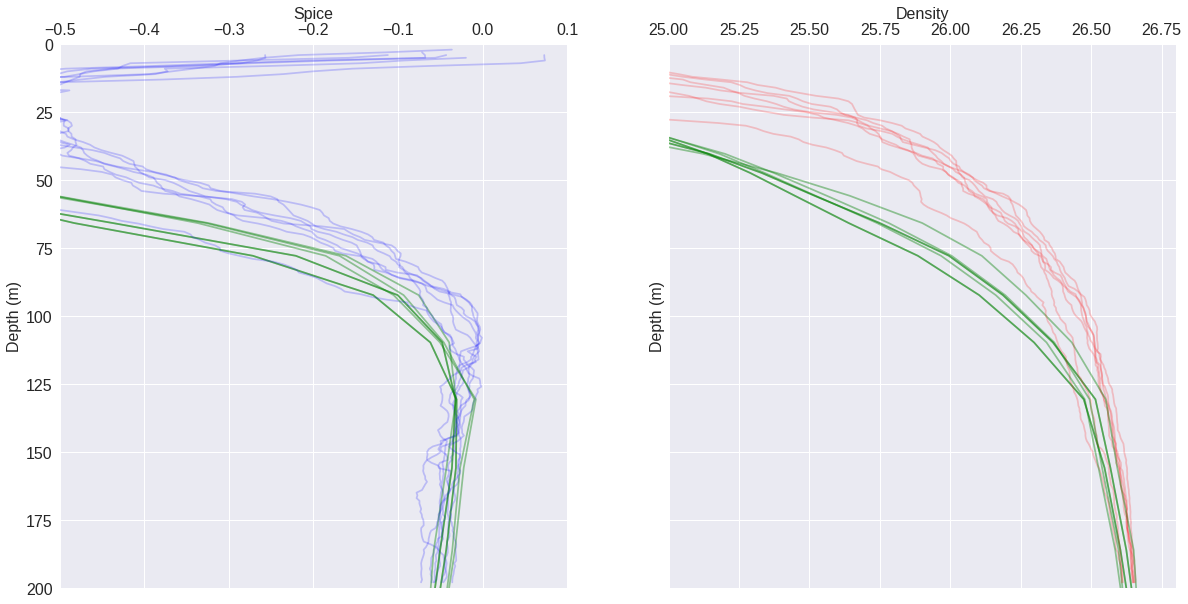

In [124]:
print("At shelf break depth upstream and downstream of Barkley Canyon")

model_maxdepth_spic[model_maxdepth_spic < -10] = np.nan
model_maxdepth_rho[model_maxdepth_rho - 1000 < 0] = np.nan

# fig2, (ax2, ax3, ax4) = plt.subplots(1,3,sharey=True,figsize=(15,8))

fig2, (ax1,ax2) = plt.subplots(1,2,sharey=True,figsize=(20,10))
# Temperature
for i in np.arange(p.shape[0]):
#     ax2.plot(model_survey_sal[:,i,i],zlevels[:], c = colors[i,:])
    ax2.plot(p_den_max_depth[:,i]-1000 ,depths_survey[:],  c = 'red', alpha = 0.2, label = 'MVP')
    ax2.plot(model_maxdepth_rho[:,i]-1000, zlevels[:], c = 'green', alpha = 0.4, label = 'NEP36')
    
ax2.set_ylabel('Depth (m)', fontsize = 16)
ax2.set_ylim(0,200)
ax2.set_ylim(ax2.get_ylim()[::-1]) 
ax2.set_xlabel('Density', fontsize = 16)
ax2.xaxis.set_label_position('top') 
ax2.xaxis.set_ticks_position('top') 
ax2.tick_params(axis='both',labelsize =16)
ax2.set_xlim(25,26.8)


for i in np.arange(p.shape[0]):
#     ax2.plot(model_survey_sal[:,i,i],zlevels[:], c = colors[i,:])
    ax1.plot(spic_max_depth[:,i] ,depths_survey[:], c = 'blue', alpha = 0.2, label = 'MVP')
    ax1.plot(model_maxdepth_spic[:,i], zlevels[:], c = 'green', alpha = 0.4, label = 'NEP36')
    
ax1.set_ylabel('Depth (m)', fontsize = 16)
ax1.set_ylim(0,200)
ax1.set_ylim(ax2.get_ylim()[::-1]) 
ax1.set_xlabel('Spice', fontsize = 16)
ax1.xaxis.set_label_position('top') 
ax1.xaxis.set_ticks_position('top') 
ax1.tick_params(axis='both',labelsize =16)
ax1.set_xlim(-0.5,0.1)


At shelf break depth upstream and downstream of Barkley Canyon
The model predicts a much more stratified scenario as compared to the real world


(-0.0001, 0.0025)

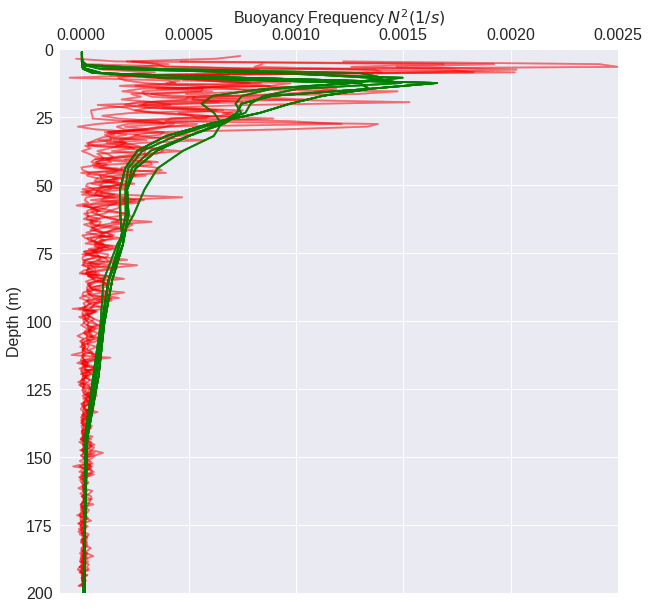

In [129]:
print("At shelf break depth upstream and downstream of Barkley Canyon")

print("The model predicts a much more stratified scenario as compared to the real world")


fig2, ax2 = plt.subplots(1,1,figsize=(10,10))
# Temperature
for i in np.arange(p.shape[0]):
    ax2.plot(N_MVP[1:,:] ,Z_N_MVP[:],  c = 'red', alpha = 0.1, label = 'MVP')
    ax2.plot(N_model[1:,:] ,Z_N_model[:], c = 'green', alpha = 0.4, label = 'NEP36')
    
ax2.set_ylabel('Depth (m)', fontsize = 16)
ax2.set_ylim(0,200)
ax2.set_ylim(ax2.get_ylim()[::-1]) 
ax2.set_xlabel('Buoyancy Frequency $N^2 (1/s)$', fontsize = 16)
ax2.xaxis.set_label_position('top') 
ax2.xaxis.set_ticks_position('top') 
ax2.tick_params(axis='both',labelsize =16)
ax2.set_xlim(-0.0001,0.0025)

In [86]:
lon_max_depth = lon_survey[np.where((max_depths < np.mean(max_depths)) & (max_depths > 118))]
lat_max_depth = lat_survey[np.where((max_depths < np.mean(max_depths)) & (max_depths > 118))]
p_den_max_depth = pden_survey[:,np.where((max_depths < np.mean(max_depths)) & (max_depths > 118))]
p_den_max_depth = p_den_max_depth[:,0,:]
temp_den_max_depth = temp_survey[:,np.where((max_depths < np.mean(max_depths)) & (max_depths > 118))]
temp_den_max_depth = temp_den_max_depth[:,0,:]
sal_den_max_depth = sal_survey[:,np.where((max_depths < np.mean(max_depths)) & (max_depths > 118))]
sal_den_max_depth = sal_den_max_depth[:,0,:]



q = np.empty_like(lon_max_depth)
p = np.empty_like(q)

In [87]:
for i in np.arange(lat_max_depth.shape[0]):
    q[i], p[i] = geo_tools.find_closest_model_point(
               lon_max_depth[i],lat_max_depth[i],lon,lat,tols={
        'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})

In [132]:
bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

mbathy = mask.variables['mbathy'][0,180:350, 480:650]
Z = bathy.variables['Bathymetry'][180:350, 480:650]

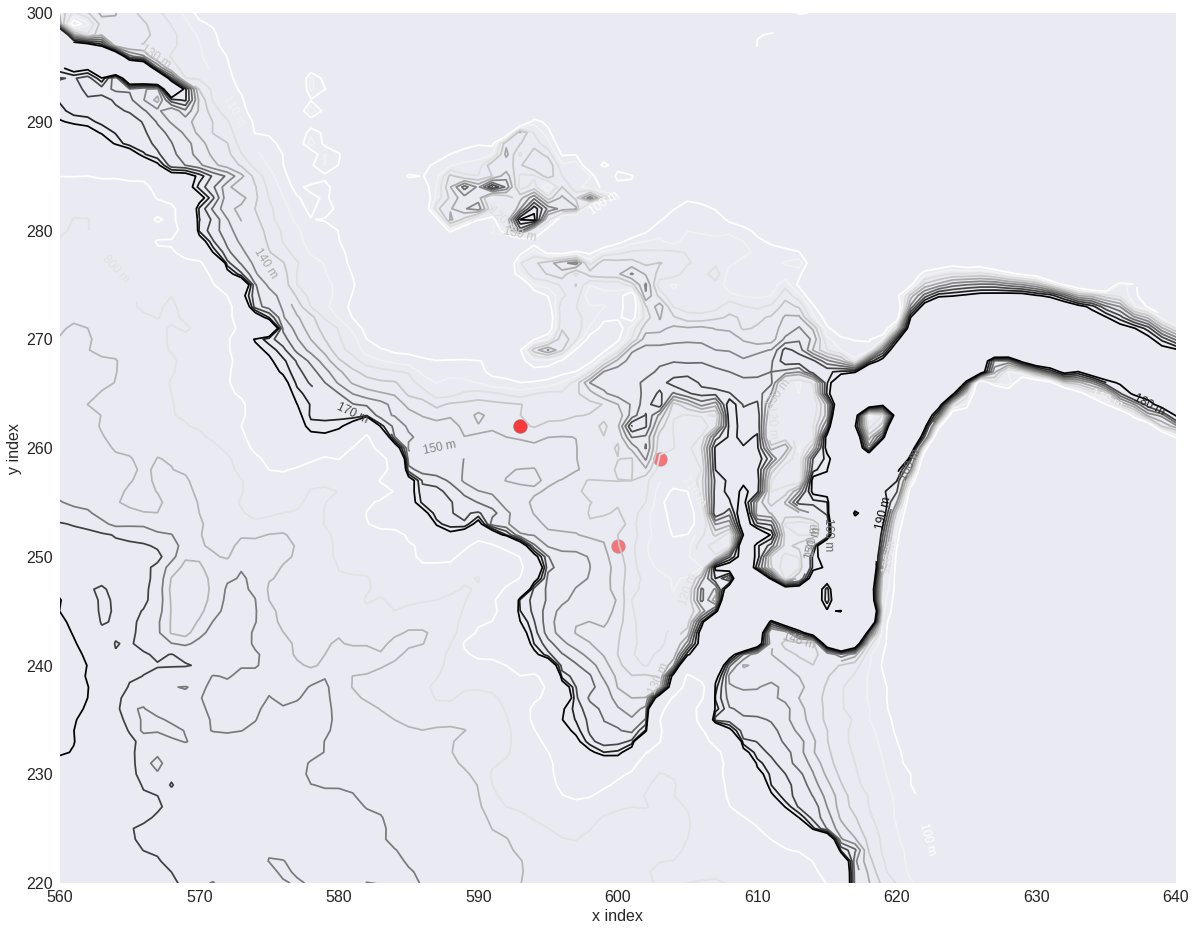

In [133]:
colors = cmo.cm.phase(np.linspace(0, 1, p.shape[0]))
# # plt.style.use('default')

# sns.set_context('paper')
# sns.set_color_codes()
# plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}
# plt.style.use('seaborn')

cmap = cmo.cm.deep
#     cmap.set_bad('burlywood')
cmap.set_bad('#8b7765')

fig, ax = plt.subplots(1, 1, figsize=(20,16)); ax.grid()
#     ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=np.mean(lon)))
CS = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[:,:], np.arange(100,200,10))
CS1 = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[:,:], level = [0,500,1000], color = 'k' )
CLS = plt.clabel(CS, inline=3,fmt='%0.0f m', fontsize=12)
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)




for i in np.arange(p.shape[0]):

    ax.scatter(x_wcvi_slice[np.int(p[i])], y_wcvi_slice[np.int(q[i])], c = 'Red', cmap = cmap, s=200, alpha=0.5, edgecolor= 'cyan' )


ax.set_ylim(220,300)
ax.set_xlim(560,640)
    
ax.set_xlabel('x index', fontsize =16)
ax.set_ylabel('y index', fontsize = 16)
ax.tick_params(axis='both',labelsize =16)


In [134]:
pressure = np.empty_like(sal_den_max_depth)
SA = np.empty_like(pressure)
CT = np.empty_like(SA)
spic_max_depth = np.empty_like(SA)
N_MVP = np.empty_like(SA)
pmid = np.empty_like(N_MVP)
Z_N_MVP = np.empty((pmid.shape[0]-1))


for j in np.arange(depths_survey.shape[0]):

    for i in np.arange(p.shape[0]):

        pressure[j,i] = gsw.p_from_z(-depths_survey[j],lat_max_depth[i])

        SA[j,i] = gsw.SA_from_SP(sal_den_max_depth[j,i], pressure[j,i], lon_max_depth[i], lat_max_depth[i])

        CT[j,i] = gsw.CT_from_pt(sal_den_max_depth[j,i], temp_den_max_depth[j,i])

        spic_max_depth[j,i] = gsw.spiciness0(SA[j,i], CT[j,i])
        
        
for i in np.arange(p.shape[0]): 
    N_MVP[1:,i],pmid[1:,i] = gsw.stability.Nsquared(SA[:,i], CT[:,i], pressure[:,i], lat_max_depth[0])
    
Z_N_MVP[:] = -gsw.z_from_p(pmid[1:,0], lat_max_depth[0])

model_maxdepth_sal = np.empty((sal.shape[1],q.shape[0]))
model_maxdepth_temp = np.empty_like(model_maxdepth_sal)
model_maxdepth_rho = np.empty_like(model_maxdepth_sal)
model_maxdepth_spic = np.empty_like(model_maxdepth_sal)

t = 116



for i in np.arange(p.shape[0]):
    model_maxdepth_sal[:,i]   = sal[t,:,q[i],p[i]]
    model_maxdepth_temp[:,i]  = temp[t,:,q[i],p[i]]
    model_maxdepth_spic[:,i]  = spic[t,:,q[i],p[i]]
    model_maxdepth_rho[:,i]   = rho[t,:,q[i],p[i]]
    


pressure_model = np.empty_like(model_maxdepth_sal)
SA_model = np.empty_like(pressure_model)
CT_model = np.empty_like(SA_model)
N_model = np.empty_like(SA_model)
pmid_model = np.empty_like(N_model)
Z_N_model = np.empty((pmid_model.shape[0]-1))
    
for j in np.arange(model_maxdepth_sal.shape[0]):

    for i in np.arange(model_maxdepth_sal.shape[1]):

        pressure_model[j,i] = gsw.p_from_z(-zlevels[j],lat_max_depth[0])

        SA_model[j,i] = gsw.SA_from_SP(model_maxdepth_sal[j,i], pressure_model[j,i], lon_max_depth[i], lat_max_depth[i])

        CT_model[j,i] = gsw.CT_from_pt(model_maxdepth_sal[j,i], model_maxdepth_temp[j,i])
    

for i in np.arange(p.shape[0]): 
    N_model[1:,i],pmid_model[1:,i] = gsw.stability.Nsquared(SA_model[:,i], CT_model[:,i], pressure_model[:,i], lat_max_depth[0])
    
Z_N_model[:] = -gsw.z_from_p(pmid_model[1:,0], lat_max_depth[0])

Onshore shelf region


/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()
/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in less


(-0.7, 0.1)

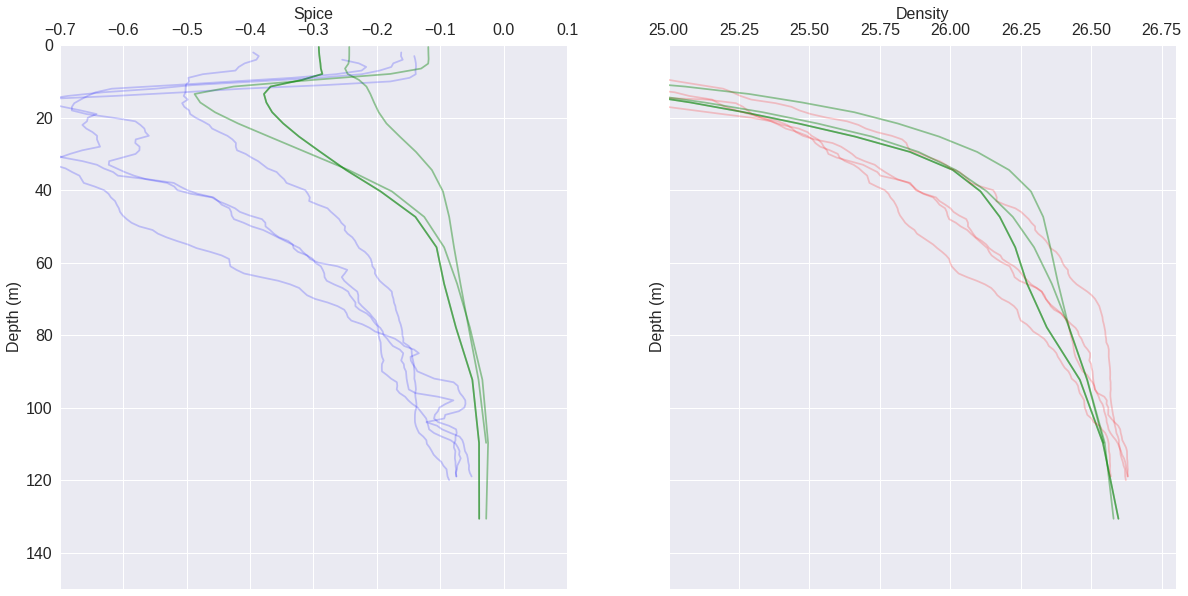

In [136]:
print("Onshore shelf region")

model_maxdepth_spic[model_maxdepth_spic < -10] = np.nan
model_maxdepth_rho[model_maxdepth_rho - 1000 < 0] = np.nan
# fig2, (ax2, ax3, ax4) = plt.subplots(1,3,sharey=True,figsize=(15,8))

fig2, (ax1,ax2) = plt.subplots(1,2,sharey=True,figsize=(20,10))
# Temperature
for i in np.arange(p.shape[0]):
#     ax2.plot(model_survey_sal[:,i,i],zlevels[:], c = colors[i,:])
    ax2.plot(p_den_max_depth[:,i]-1000 ,depths_survey[:],  c = 'red', alpha = 0.2, label = 'MVP')
    ax2.plot(model_maxdepth_rho[:,i]-1000, zlevels[:], c = 'green', alpha = 0.4, label = 'NEP36')
    
ax2.set_ylabel('Depth (m)', fontsize = 16)
ax2.set_ylim(0,150)
ax2.set_ylim(ax2.get_ylim()[::-1]) 
ax2.set_xlabel('Density', fontsize = 16)
ax2.xaxis.set_label_position('top') 
ax2.xaxis.set_ticks_position('top') 
ax2.tick_params(axis='both',labelsize =16)
ax2.set_xlim(25,26.8)


for i in np.arange(p.shape[0]):
#     ax2.plot(model_survey_sal[:,i,i],zlevels[:], c = colors[i,:])
    ax1.plot(spic_max_depth[:,i] ,depths_survey[:], c = 'blue', alpha = 0.2, label = 'MVP')
    ax1.plot(model_maxdepth_spic[:,i], zlevels[:], c = 'green', alpha = 0.4, label = 'NEP36')
    
ax1.set_ylabel('Depth (m)', fontsize = 16)
ax1.set_ylim(0,150)
ax1.set_ylim(ax2.get_ylim()[::-1]) 
ax1.set_xlabel('Spice', fontsize = 16)
ax1.xaxis.set_label_position('top') 
ax1.xaxis.set_ticks_position('top') 
ax1.tick_params(axis='both',labelsize =16)
ax1.set_xlim(-0.7,0.1)


At shelf break depth upstream and downstream of Barkley Canyon
The model predicts a much more stratified scenario as compared to the real world


/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in less


(-0.0001, 0.0025)

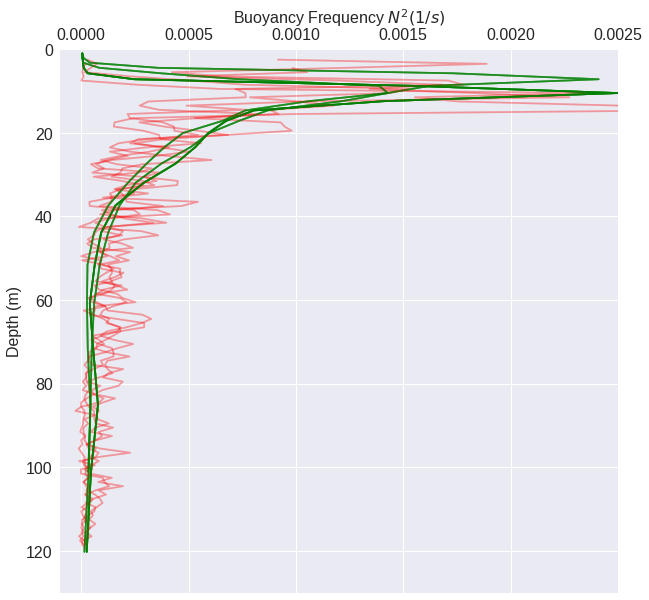

In [138]:
print("At shelf break depth upstream and downstream of Barkley Canyon")

print("The model predicts a much more stratified scenario as compared to the real world")

N_model[N_model < -0.005]  = np.nan

fig2, ax2 = plt.subplots(1,1,figsize=(10,10))
# Temperature
for i in np.arange(p.shape[0]):
    ax2.plot(N_MVP[1:,:] ,Z_N_MVP[:],  c = 'red', alpha = 0.1, label = 'MVP')
    ax2.plot(N_model[1:,:] ,Z_N_model[:], c = 'green', alpha = 0.4, label = 'NEP36')
    
ax2.set_ylabel('Depth (m)', fontsize = 16)
ax2.set_ylim(0,130)
ax2.set_ylim(ax2.get_ylim()[::-1]) 
ax2.set_xlabel('Buoyancy Frequency $N^2 (1/s)$', fontsize = 16)
ax2.xaxis.set_label_position('top') 
ax2.xaxis.set_ticks_position('top') 
ax2.tick_params(axis='both',labelsize =16)
ax2.set_xlim(-0.0001,0.0025)

In [155]:
file = survey_file_E

In [156]:
mat = scipy.io.loadmat(file)

depths_survey = mat['depths'][:,0]
lat_survey = mat['latitude'][:,0]
lon_survey = mat['longitude'][:,0] - 100
# den_survey = mat['density'][:]
pden_survey = mat['pden'][:]
temp_survey = mat['temp'][:]
sal_survey = mat['salinity'][:]
mtime = mat['mtime'][:,0]

In [157]:
y = np.empty_like(temp_survey)

max_depths = np.empty((temp_survey.shape[1]))

y[:,:] = np.isnan(temp_survey)

for i in np.arange(max_depths.shape[0]):
    if (np.isfinite(temp_survey[:,i])).any() == True:
        max_depths[i] = np.max(depths_survey[np.isfinite(temp_survey[:,i])])

In [158]:
lon_max_depth = lon_survey[np.where(max_depths == np.max(max_depths))]
lat_max_depth = lat_survey[np.where(max_depths == np.max(max_depths))]
p_den_max_depth = pden_survey[:,np.where(max_depths == np.max(max_depths))]
p_den_max_depth = p_den_max_depth[:,0,:]
temp_den_max_depth = temp_survey[:,np.where(max_depths == np.max(max_depths))]
temp_den_max_depth = temp_den_max_depth[:,0,:]
sal_den_max_depth = sal_survey[:,np.where(max_depths == np.max(max_depths))]
sal_den_max_depth = sal_den_max_depth[:,0,:]



q = np.empty_like(lon_max_depth)
p = np.empty_like(q)

In [159]:
for i in np.arange(lat_max_depth.shape[0]):
    q[i], p[i] = geo_tools.find_closest_model_point(
               lon_max_depth[i],lat_max_depth[i],lon,lat,tols={
        'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})

In [15]:
bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

mbathy = mask.variables['mbathy'][0,180:350, 480:650]
Z = bathy.variables['Bathymetry'][180:350, 480:650]

In [239]:
p

array([ 128.,  128.,  127.,  115.,  115.,  114.,  113.,   89.,   99.,
         97.,   95.,   95.,   94.,   93.,   91.,   91.,   91.,   91.,
         91.,   92.,   92.,   93.,   94.,   94.,   96.,   96.,   98.,
         99.,  101.,  101.,  102.,  104.,  104.,  105.,  104.,  103.,
        103.,  102.,  101.,  100.,  100.,   99.,   98.,   95.,   93.,   92.])

In [160]:
p1 = p[q>70]
q1 = q[p<100]
q = q1[q1>70]
p = p1[p1<100]

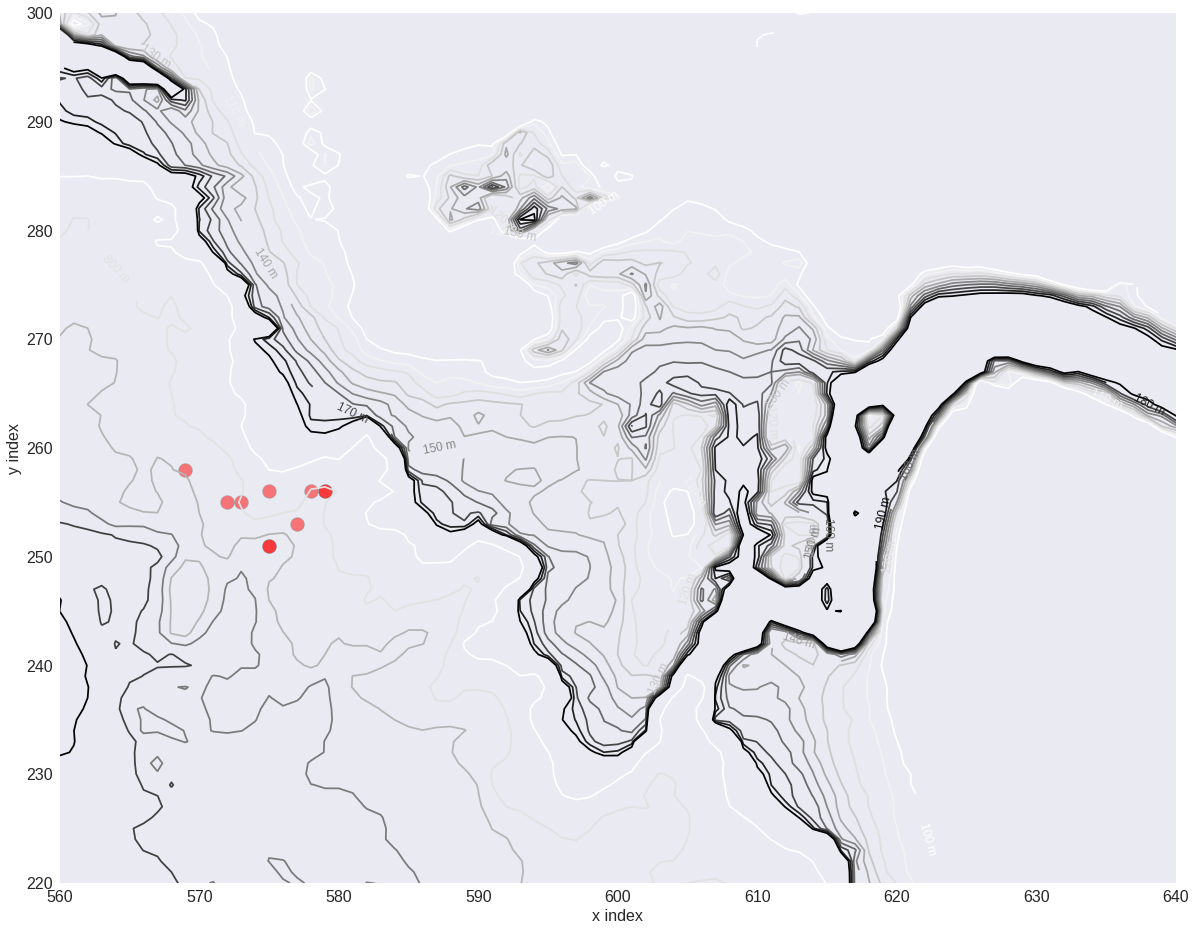

In [241]:
colors = cmo.cm.phase(np.linspace(0, 1, p.shape[0]))
# # plt.style.use('default')

# sns.set_context('paper')
# sns.set_color_codes()
# plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}
# plt.style.use('seaborn')

cmap = cmo.cm.deep
#     cmap.set_bad('burlywood')
cmap.set_bad('#8b7765')

fig, ax = plt.subplots(1, 1, figsize=(20,16)); ax.grid()
#     ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=np.mean(lon)))
CS = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[:,:], np.arange(100,200,10))
CS1 = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[:,:], level = [0,500,1000], color = 'k' )
CLS = plt.clabel(CS, inline=3,fmt='%0.0f m', fontsize=12)
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)




for i in np.arange(p.shape[0]):

    ax.scatter(x_wcvi_slice[np.int(p[i])], y_wcvi_slice[np.int(q[i])], c = 'Red', cmap = cmap, s=200, alpha=0.5, edgecolor= 'cyan' )


ax.set_ylim(220,300)
ax.set_xlim(560,640)
    
ax.set_xlabel('x index', fontsize =16)
ax.set_ylabel('y index', fontsize = 16)
ax.tick_params(axis='both',labelsize =16)


In [242]:
pressure = np.empty_like(sal_den_max_depth)
SA = np.empty_like(pressure)
CT = np.empty_like(SA)
spic_max_depth = np.empty_like(SA)
N_MVP = np.empty_like(SA)
pmid = np.empty_like(N_MVP)
Z_N_MVP = np.empty((pmid.shape[0]-1))


for j in np.arange(depths_survey.shape[0]):

    for i in np.arange(p.shape[0]):

        pressure[j,i] = gsw.p_from_z(-depths_survey[j],lat_max_depth[i])

        SA[j,i] = gsw.SA_from_SP(sal_den_max_depth[j,i], pressure[j,i], lon_max_depth[i], lat_max_depth[i])

        CT[j,i] = gsw.CT_from_pt(sal_den_max_depth[j,i], temp_den_max_depth[j,i])

        spic_max_depth[j,i] = gsw.spiciness0(SA[j,i], CT[j,i])
        
        
for i in np.arange(p.shape[0]): 
    N_MVP[1:,i],pmid[1:,i] = gsw.stability.Nsquared(SA[:,i], CT[:,i], pressure[:,i], lat_max_depth[0])
    
Z_N_MVP[:] = -gsw.z_from_p(pmid[1:,0], lat_max_depth[0])

model_maxdepth_sal = np.empty((sal.shape[1],q.shape[0]))
model_maxdepth_temp = np.empty_like(model_maxdepth_sal)
model_maxdepth_rho = np.empty_like(model_maxdepth_sal)
model_maxdepth_spic = np.empty_like(model_maxdepth_sal)

t = 116



for i in np.arange(p.shape[0]):
    model_maxdepth_sal[:,i]   = sal[t,:,q[i],p[i]]
    model_maxdepth_temp[:,i]  = temp[t,:,q[i],p[i]]
    model_maxdepth_spic[:,i]  = spic[t,:,q[i],p[i]]
    model_maxdepth_rho[:,i]   = rho[t,:,q[i],p[i]]
    


pressure_model = np.empty_like(model_maxdepth_sal)
SA_model = np.empty_like(pressure_model)
CT_model = np.empty_like(SA_model)
N_model = np.empty_like(SA_model)
pmid_model = np.empty_like(N_model)
Z_N_model = np.empty((pmid_model.shape[0]-1))
    
for j in np.arange(model_maxdepth_sal.shape[0]):

    for i in np.arange(model_maxdepth_sal.shape[1]):

        pressure_model[j,i] = gsw.p_from_z(-zlevels[j],lat_max_depth[0])

        SA_model[j,i] = gsw.SA_from_SP(model_maxdepth_sal[j,i], pressure_model[j,i], lon_max_depth[i], lat_max_depth[i])

        CT_model[j,i] = gsw.CT_from_pt(model_maxdepth_sal[j,i], model_maxdepth_temp[j,i])
    

for i in np.arange(p.shape[0]): 
    N_model[1:,i],pmid_model[1:,i] = gsw.stability.Nsquared(SA_model[:,i], CT_model[:,i], pressure_model[:,i], lat_max_depth[0])
    
Z_N_model[:] = -gsw.z_from_p(pmid_model[1:,0], lat_max_depth[0])

Onshore shelf region


(-0.7, 0.1)

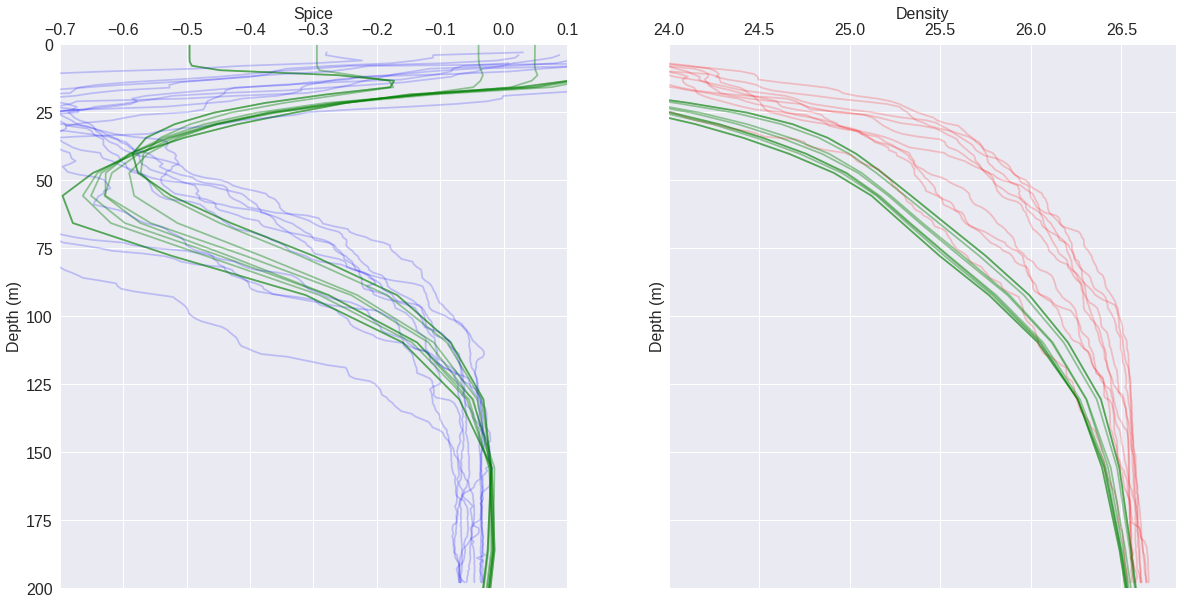

In [245]:
print("Onshore shelf region")

model_maxdepth_spic[model_maxdepth_spic < -10] = np.nan
model_maxdepth_rho[model_maxdepth_rho - 1000 < 0] = np.nan
# fig2, (ax2, ax3, ax4) = plt.subplots(1,3,sharey=True,figsize=(15,8))

fig2, (ax1,ax2) = plt.subplots(1,2,sharey=True,figsize=(20,10))
# Temperature
for i in np.arange(p.shape[0]):
#     ax2.plot(model_survey_sal[:,i,i],zlevels[:], c = colors[i,:])
    ax2.plot(p_den_max_depth[:,i]-1000 ,depths_survey[:],  c = 'red', alpha = 0.2, label = 'MVP')
    ax2.plot(model_maxdepth_rho[:,i]-1000, zlevels[:], c = 'green', alpha = 0.4, label = 'NEP36')
    
ax2.set_ylabel('Depth (m)', fontsize = 16)
ax2.set_ylim(0,150)
ax2.set_ylim(ax2.get_ylim()[::-1]) 
ax2.set_xlabel('Density', fontsize = 16)
ax2.xaxis.set_label_position('top') 
ax2.xaxis.set_ticks_position('top') 
ax2.tick_params(axis='both',labelsize =16)
ax2.set_xlim(24,26.8)


for i in np.arange(p.shape[0]):
#     ax2.plot(model_survey_sal[:,i,i],zlevels[:], c = colors[i,:])
    ax1.plot(spic_max_depth[:,i] ,depths_survey[:], c = 'blue', alpha = 0.2, label = 'MVP')
    ax1.plot(model_maxdepth_spic[:,i], zlevels[:], c = 'green', alpha = 0.4, label = 'NEP36')
    
ax1.set_ylabel('Depth (m)', fontsize = 16)
ax1.set_ylim(0,200)
ax1.set_ylim(ax2.get_ylim()[::-1]) 
ax1.set_xlabel('Spice', fontsize = 16)
ax1.xaxis.set_label_position('top') 
ax1.xaxis.set_ticks_position('top') 
ax1.tick_params(axis='both',labelsize =16)
ax1.set_xlim(-0.7,0.1)


At shelf break depth upstream and downstream of Barkley Canyon
The model predicts a much more stratified scenario as compared to the real world


/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/transforms.py:2786: RuntimeWarning: overflow encountered in double_scalars
  elif vmax - vmin <= maxabsvalue * tiny:
/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_base.py:2322: RuntimeWarning: overflow encountered in double_scalars
  delta = (x1t - x0t) * margin


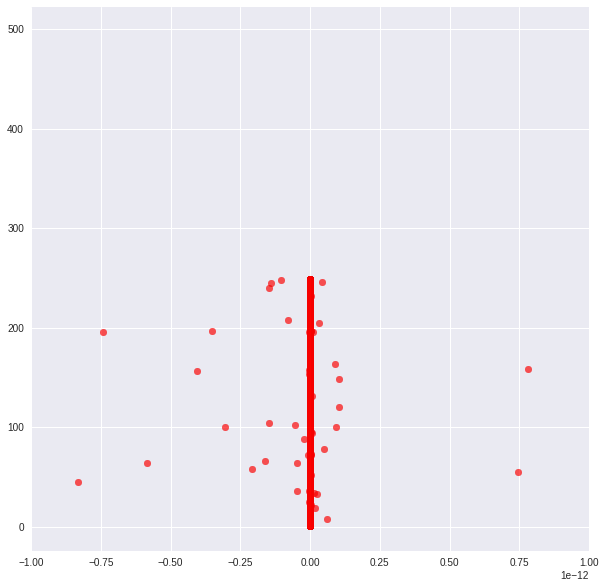

In [261]:
print("At shelf break depth upstream and downstream of Barkley Canyon")

print("The model predicts a much more stratified scenario as compared to the real world")

N_model[N_model < -0.005]  = np.nan

N_model = np.array(N_model, dtype=np.float64)
fig2, ax2 = plt.subplots(1,1,figsize=(10,10))
# Temperature
for i in np.arange(p.shape[0]):
    ax2.plot(N_MVP[1:,:] ,Z_N_MVP[:], 'o', c = 'red', alpha = 0.1, label = 'MVP')
    ax2.plot(N_model[1:,:] ,Z_N_model[:], 'o',c = 'green', alpha = 0.4, label = 'NEP36')
    
# ax2.set_ylabel('Depth (m)', fontsize = 16)
# ax2.set_ylim(0,200)
# ax2.set_ylim(ax2.get_ylim()[::-1]) 
# ax2.set_xlabel('Buoyancy Frequency $N^2 (1/s)$', fontsize = 16)
# ax2.xaxis.set_label_position('top') 
# ax2.xaxis.set_ticks_position('top') 
# ax2.tick_params(axis='both',labelsize =16)
# ax2.set_xlim(-0.0001,0.0025)

In [130]:
file = survey_file_D

In [131]:
mat = scipy.io.loadmat(file)

depths_survey = mat['depths'][:,0]
lat_survey = mat['latitude'][:,0]
lon_survey = mat['longitude'][:,0] - 100
# den_survey = mat['density'][:]
pden_survey = mat['pden'][:]
temp_survey = mat['temp'][:]
sal_survey = mat['salinity'][:]
mtime = mat['mtime'][:,0]

In [132]:
y = np.empty_like(temp_survey)

max_depths = np.empty((temp_survey.shape[1]))

y[:,:] = np.isnan(temp_survey)

for i in np.arange(max_depths.shape[0]):
    if (np.isfinite(temp_survey[:,i])).any() == True:
        max_depths[i] = np.max(depths_survey[np.isfinite(temp_survey[:,i])])

In [24]:
lon_max_depth = lon_survey[np.where((max_depths < np.mean(max_depths)+20))]# & (max_depths > 118))]
lat_max_depth = lat_survey[np.where((max_depths < np.mean(max_depths)+20))]# & (max_depths > 118))]
p_den_max_depth = pden_survey[:,np.where((max_depths < np.mean(max_depths)+20))]# & (max_depths > 118))]
p_den_max_depth = p_den_max_depth[:,0,:]
temp_den_max_depth = temp_survey[:,np.where((max_depths < np.mean(max_depths)+20))]# & (max_depths > 118))]
temp_den_max_depth = temp_den_max_depth[:,0,:]
sal_den_max_depth = sal_survey[:,np.where((max_depths < np.mean(max_depths)+20))]# & (max_depths > 118))]
sal_den_max_depth = sal_den_max_depth[:,0,:]



q = np.empty_like(lon_max_depth)
p = np.empty_like(q)

In [25]:
for i in np.arange(lat_max_depth.shape[0]):
    q[i], p[i] = geo_tools.find_closest_model_point(
               lon_max_depth[i],lat_max_depth[i],lon,lat,tols={
        'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})

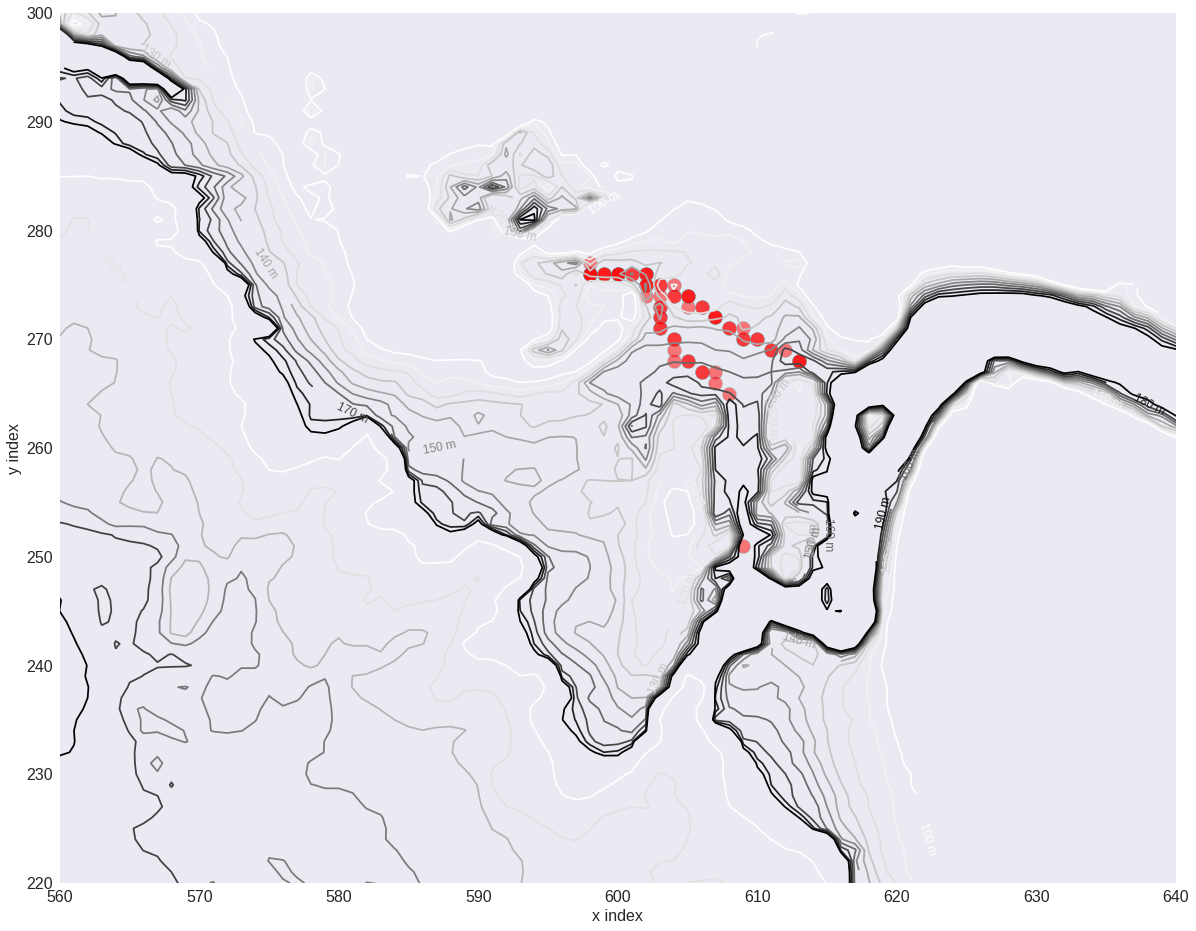

In [26]:
colors = cmo.cm.phase(np.linspace(0, 1, p.shape[0]))
# # plt.style.use('default')

# sns.set_context('paper')
# sns.set_color_codes()
# plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}
# plt.style.use('seaborn')

cmap = cmo.cm.deep
#     cmap.set_bad('burlywood')
cmap.set_bad('#8b7765')

fig, ax = plt.subplots(1, 1, figsize=(20,16)); ax.grid()
#     ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=np.mean(lon)))
CS = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[:,:], np.arange(100,200,10))
CS1 = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[:,:], level = [0,500,1000], color = 'k' )
CLS = plt.clabel(CS, inline=3,fmt='%0.0f m', fontsize=12)
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)




for i in np.arange(p.shape[0]):

    ax.scatter(x_wcvi_slice[np.int(p[i])], y_wcvi_slice[np.int(q[i])], c = 'Red', cmap = cmap, s=200, alpha=0.5, edgecolor= 'cyan' )


ax.set_ylim(220,300)
ax.set_xlim(560,640)
    
ax.set_xlabel('x index', fontsize =16)
ax.set_ylabel('y index', fontsize = 16)
ax.tick_params(axis='both',labelsize =16)


In [27]:
pressure = np.empty_like(sal_den_max_depth)
SA = np.empty_like(pressure)
CT = np.empty_like(SA)
spic_max_depth = np.empty_like(SA)
N_MVP = np.empty_like(SA)
pmid = np.empty_like(N_MVP)
Z_N_MVP = np.empty((pmid.shape[0]-1))


for j in np.arange(depths_survey.shape[0]):

    for i in np.arange(p.shape[0]):

        pressure[j,i] = gsw.p_from_z(-depths_survey[j],lat_max_depth[i])

        SA[j,i] = gsw.SA_from_SP(sal_den_max_depth[j,i], pressure[j,i], lon_max_depth[i], lat_max_depth[i])

        CT[j,i] = gsw.CT_from_pt(sal_den_max_depth[j,i], temp_den_max_depth[j,i])

        spic_max_depth[j,i] = gsw.spiciness0(SA[j,i], CT[j,i])
        
        
for i in np.arange(p.shape[0]): 
    N_MVP[1:,i],pmid[1:,i] = gsw.stability.Nsquared(SA[:,i], CT[:,i], pressure[:,i], lat_max_depth[0])
    
Z_N_MVP[:] = -gsw.z_from_p(pmid[1:,0], lat_max_depth[0])

model_maxdepth_sal = np.empty((sal.shape[1],q.shape[0]))
model_maxdepth_temp = np.empty_like(model_maxdepth_sal)
model_maxdepth_rho = np.empty_like(model_maxdepth_sal)
model_maxdepth_spic = np.empty_like(model_maxdepth_sal)

t = 118



for i in np.arange(p.shape[0]):
    model_maxdepth_sal[:,i]   = sal[t,:,q[i],p[i]]
    model_maxdepth_temp[:,i]  = temp[t,:,q[i],p[i]]
    model_maxdepth_spic[:,i]  = spic[t,:,q[i],p[i]]
    model_maxdepth_rho[:,i]   = rho[t,:,q[i],p[i]]
    


pressure_model = np.empty_like(model_maxdepth_sal)
SA_model = np.empty_like(pressure_model)
CT_model = np.empty_like(SA_model)
N_model = np.empty_like(SA_model)
pmid_model = np.empty_like(N_model)
Z_N_model = np.empty((pmid_model.shape[0]-1))
    
for j in np.arange(model_maxdepth_sal.shape[0]):

    for i in np.arange(model_maxdepth_sal.shape[1]):

        pressure_model[j,i] = gsw.p_from_z(-zlevels[j],lat_max_depth[0])

        SA_model[j,i] = gsw.SA_from_SP(model_maxdepth_sal[j,i], pressure_model[j,i], lon_max_depth[i], lat_max_depth[i])

        CT_model[j,i] = gsw.CT_from_pt(model_maxdepth_sal[j,i], model_maxdepth_temp[j,i])
    

for i in np.arange(p.shape[0]): 
    N_model[1:,i],pmid_model[1:,i] = gsw.stability.Nsquared(SA_model[:,i], CT_model[:,i], pressure_model[:,i], lat_max_depth[0])
    
Z_N_model[:] = -gsw.z_from_p(pmid_model[1:,0], lat_max_depth[0])

Onshore shelf region


(-0.7, 0.1)

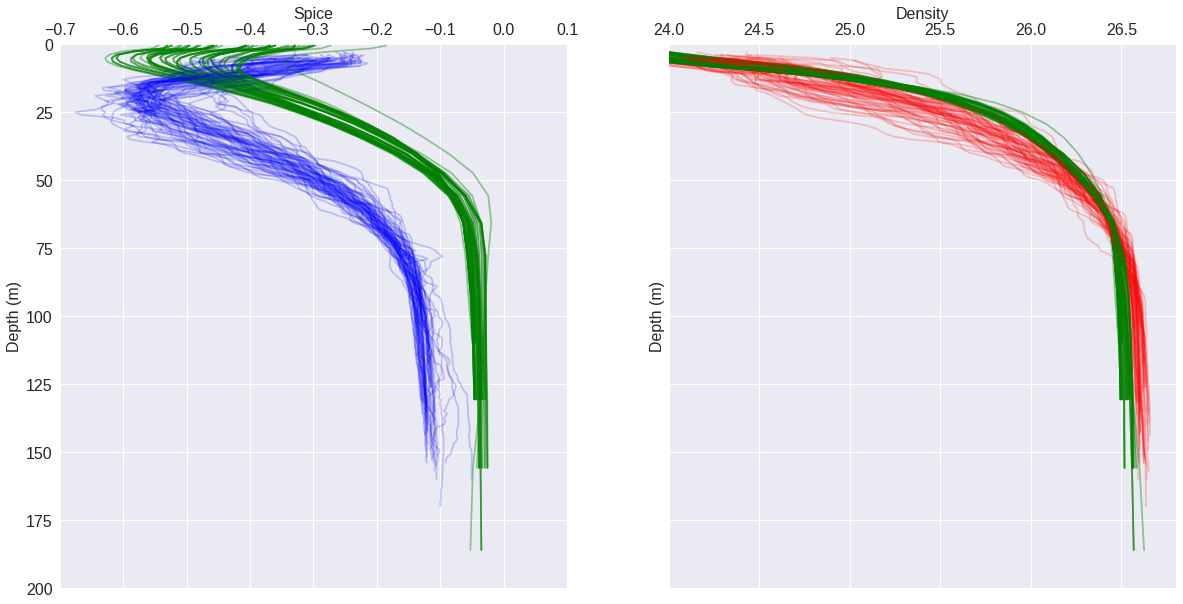

In [28]:
print("Onshore shelf region")

model_maxdepth_spic[model_maxdepth_spic < -10] = np.nan
model_maxdepth_rho[model_maxdepth_rho - 1000 < 0] = np.nan
# fig2, (ax2, ax3, ax4) = plt.subplots(1,3,sharey=True,figsize=(15,8))

fig2, (ax1,ax2) = plt.subplots(1,2,sharey=True,figsize=(20,10))
# Temperature
for i in np.arange(p.shape[0]):
#     ax2.plot(model_survey_sal[:,i,i],zlevels[:], c = colors[i,:])
    ax2.plot(p_den_max_depth[:,i]-1000 ,depths_survey[:],  c = 'red', alpha = 0.2, label = 'MVP')
    ax2.plot(model_maxdepth_rho[:,i]-1000, zlevels[:], c = 'green', alpha = 0.4, label = 'NEP36')
    
ax2.set_ylabel('Depth (m)', fontsize = 16)
ax2.set_ylim(0,150)
ax2.set_ylim(ax2.get_ylim()[::-1]) 
ax2.set_xlabel('Density', fontsize = 16)
ax2.xaxis.set_label_position('top') 
ax2.xaxis.set_ticks_position('top') 
ax2.tick_params(axis='both',labelsize =16)
ax2.set_xlim(24,26.8)


for i in np.arange(p.shape[0]):
#     ax2.plot(model_survey_sal[:,i,i],zlevels[:], c = colors[i,:])
    ax1.plot(spic_max_depth[:,i] ,depths_survey[:], c = 'blue', alpha = 0.2, label = 'MVP')
    ax1.plot(model_maxdepth_spic[:,i], zlevels[:], c = 'green', alpha = 0.4, label = 'NEP36')
    
ax1.set_ylabel('Depth (m)', fontsize = 16)
ax1.set_ylim(0,200)
ax1.set_ylim(ax2.get_ylim()[::-1]) 
ax1.set_xlabel('Spice', fontsize = 16)
ax1.xaxis.set_label_position('top') 
ax1.xaxis.set_ticks_position('top') 
ax1.tick_params(axis='both',labelsize =16)
ax1.set_xlim(-0.7,0.1)


In [181]:
import numpy

def smooth(x,window_len=7,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise "smooth only accepts 1 dimension arrays."

    if x.size < window_len:
        raise "Input vector needs to be bigger than window size."


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'"


    s=numpy.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=numpy.ones(window_len,'d')
    else:
        w=eval('numpy.'+window+'(window_len)')

    y=numpy.convolve(w/w.sum(),s, mode='same')
    
    return y[window_len - 1:-window_len + 1]



In [59]:
N_smooth = np.empty_like(N_MVP)

for i in np.arange(N_MVP.shape[1]):
    N_smooth[:,i] = smooth(N_MVP[:,i],20,'hanning')

(-0.0001, 0.0025)

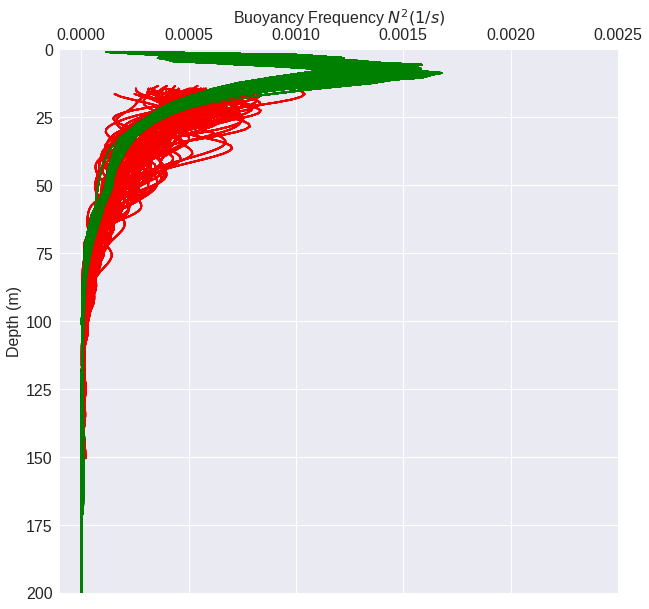

In [60]:
fig2, ax2 = plt.subplots(1,1,figsize=(10,10))
# Temperature
for i in np.arange(p.shape[0]):
    ax2.plot(N_smooth[1:,:] ,Z_N_MVP[:],  c = 'red', alpha = 0.1, label = 'MVP')
    ax2.plot(N_model[1:,:] ,Z_N_model[:], c = 'green', alpha = 0.4, label = 'NEP36')
    
ax2.set_ylabel('Depth (m)', fontsize = 16)
ax2.set_ylim(0,200)
ax2.set_ylim(ax2.get_ylim()[::-1]) 
ax2.set_xlabel('Buoyancy Frequency $N^2 (1/s)$', fontsize = 16)
ax2.xaxis.set_label_position('top') 
ax2.xaxis.set_ticks_position('top') 
ax2.tick_params(axis='both',labelsize =16)
ax2.set_xlim(-0.0001,0.0025)

(-0.0001, 0.0025)

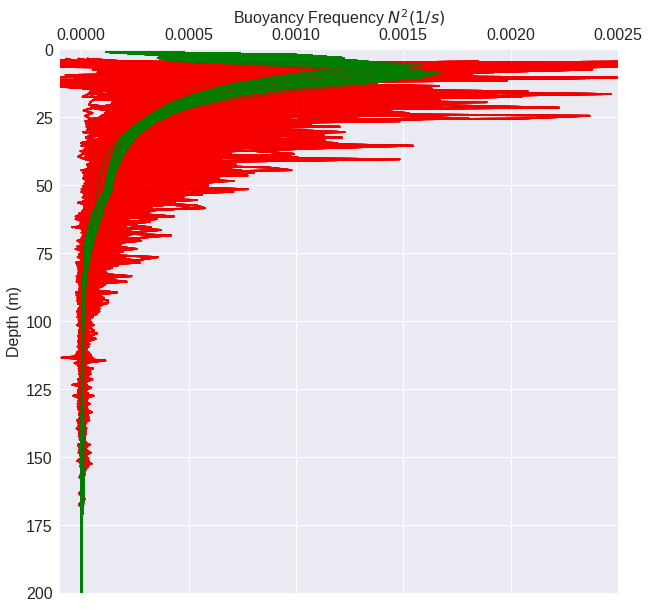

In [31]:
fig2, ax2 = plt.subplots(1,1,figsize=(10,10))
# Temperature
for i in np.arange(p.shape[0]):
    ax2.plot(N_MVP[1:,:] ,Z_N_MVP[:],  c = 'red', alpha = 0.1, label = 'MVP')
    ax2.plot(N_model[1:,:] ,Z_N_model[:], c = 'green', alpha = 0.4, label = 'NEP36')
    
ax2.set_ylabel('Depth (m)', fontsize = 16)
ax2.set_ylim(0,200)
ax2.set_ylim(ax2.get_ylim()[::-1]) 
ax2.set_xlabel('Buoyancy Frequency $N^2 (1/s)$', fontsize = 16)
ax2.xaxis.set_label_position('top') 
ax2.xaxis.set_ticks_position('top') 
ax2.tick_params(axis='both',labelsize =16)
ax2.set_xlim(-0.0001,0.0025)

In [133]:
lon_max_depth = lon_survey[np.where((max_depths > np.mean(max_depths)))]# & (max_depths > 118))]
lat_max_depth = lat_survey[np.where((max_depths > np.mean(max_depths)))]# & (max_depths > 118))]
p_den_max_depth = pden_survey[:,np.where((max_depths > np.mean(max_depths)))]# & (max_depths > 118))]
p_den_max_depth = p_den_max_depth[:,0,:]
temp_den_max_depth = temp_survey[:,np.where((max_depths > np.mean(max_depths)))]# & (max_depths > 118))]
temp_den_max_depth = temp_den_max_depth[:,0,:]
sal_den_max_depth = sal_survey[:,np.where((max_depths > np.mean(max_depths)))]# & (max_depths > 118))]
sal_den_max_depth = sal_den_max_depth[:,0,:]



q = np.empty_like(lon_max_depth)
p = np.empty_like(q)

In [134]:
for i in np.arange(lat_max_depth.shape[0]):
    q[i], p[i] = geo_tools.find_closest_model_point(
               lon_max_depth[i],lat_max_depth[i],lon,lat,tols={
        'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})

In [135]:
p1 = p[q>75]
q1 = q[p<130]
q = q1[q1>75]
p = p1[p1<130]

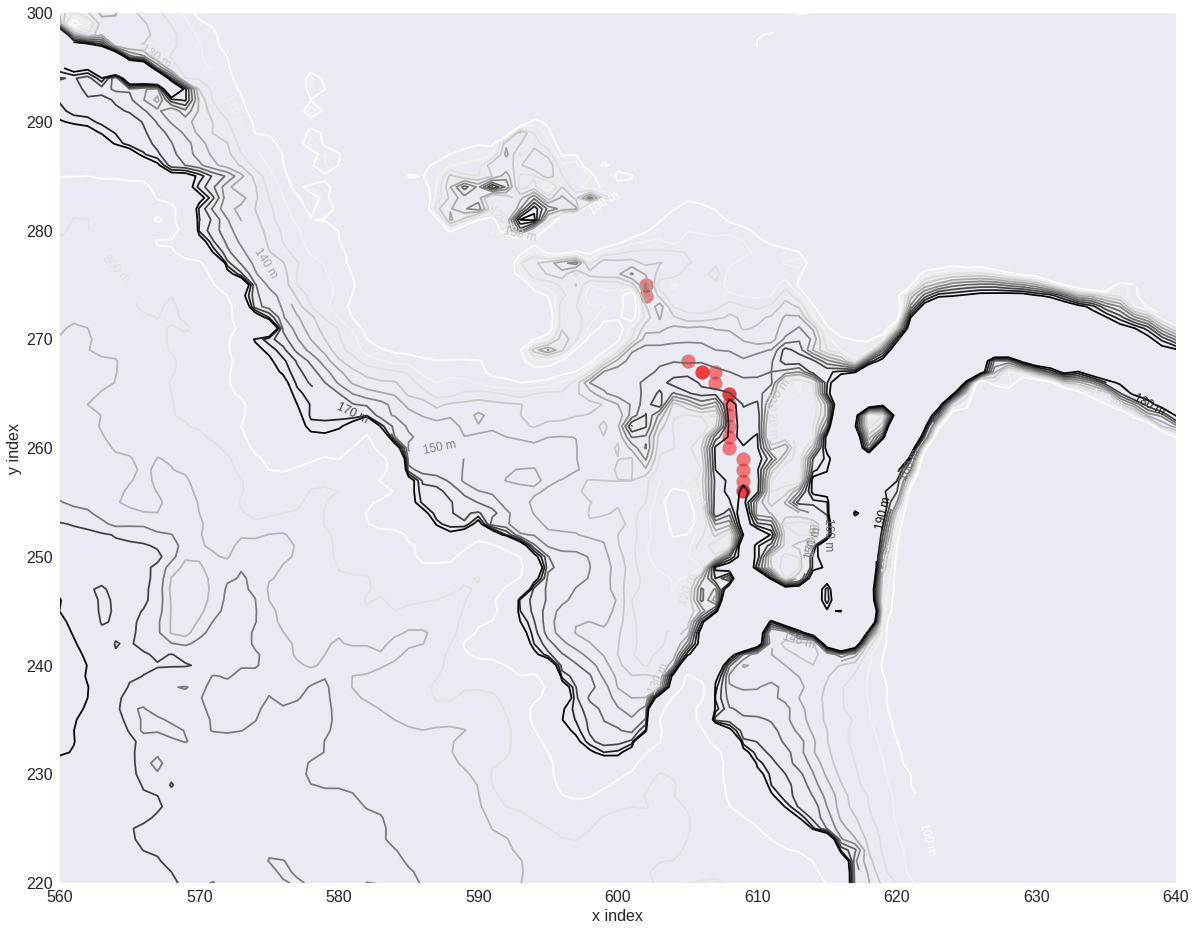

In [69]:
colors = cmo.cm.phase(np.linspace(0, 1, p.shape[0]))
# # plt.style.use('default')

# sns.set_context('paper')
# sns.set_color_codes()
# plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}
# plt.style.use('seaborn')

cmap = cmo.cm.deep
#     cmap.set_bad('burlywood')
cmap.set_bad('#8b7765')

fig, ax = plt.subplots(1, 1, figsize=(20,16)); ax.grid()
#     ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=np.mean(lon)))
CS = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[:,:], np.arange(100,200,10))
CS1 = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[:,:], level = [0,500,1000], color = 'k' )
CLS = plt.clabel(CS, inline=3,fmt='%0.0f m', fontsize=12)
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)




for i in np.arange(p.shape[0]):

    ax.scatter(x_wcvi_slice[np.int(p[i])], y_wcvi_slice[np.int(q[i])], c = 'Red', cmap = cmap, s=200, alpha=0.5, edgecolor= 'cyan' )


ax.set_ylim(220,300)
ax.set_xlim(560,640)
    
ax.set_xlabel('x index', fontsize =16)
ax.set_ylabel('y index', fontsize = 16)
ax.tick_params(axis='both',labelsize =16)


In [136]:
pressure = np.empty_like(sal_den_max_depth)
SA = np.empty_like(pressure)
CT = np.empty_like(SA)
spic_max_depth = np.empty_like(SA)
N_MVP = np.empty_like(SA)
pmid = np.empty_like(N_MVP)
Z_N_MVP = np.empty((pmid.shape[0]-1))


for j in np.arange(depths_survey.shape[0]):

    for i in np.arange(p.shape[0]):

        pressure[j,i] = gsw.p_from_z(-depths_survey[j],lat_max_depth[i])

        SA[j,i] = gsw.SA_from_SP(sal_den_max_depth[j,i], pressure[j,i], lon_max_depth[i], lat_max_depth[i])

        CT[j,i] = gsw.CT_from_pt(sal_den_max_depth[j,i], temp_den_max_depth[j,i])

        spic_max_depth[j,i] = gsw.spiciness0(SA[j,i], CT[j,i])
        
        
for i in np.arange(p.shape[0]): 
    N_MVP[1:,i],pmid[1:,i] = gsw.stability.Nsquared(SA[:,i], CT[:,i], pressure[:,i], lat_max_depth[0])
    
Z_N_MVP[:] = -gsw.z_from_p(pmid[1:,0], lat_max_depth[0])

model_maxdepth_sal = np.empty((sal.shape[1],q.shape[0]))
model_maxdepth_temp = np.empty_like(model_maxdepth_sal)
model_maxdepth_rho = np.empty_like(model_maxdepth_sal)
model_maxdepth_spic = np.empty_like(model_maxdepth_sal)

t = 118



for i in np.arange(p.shape[0]):
    model_maxdepth_sal[:,i]   = sal[t,:,q[i],p[i]]
    model_maxdepth_temp[:,i]  = temp[t,:,q[i],p[i]]
    model_maxdepth_spic[:,i]  = spic[t,:,q[i],p[i]]
    model_maxdepth_rho[:,i]   = rho[t,:,q[i],p[i]]
    


pressure_model = np.empty_like(model_maxdepth_sal)
SA_model = np.empty_like(pressure_model)
CT_model = np.empty_like(SA_model)
N_model = np.empty_like(SA_model)
pmid_model = np.empty_like(N_model)
Z_N_model = np.empty((pmid_model.shape[0]-1))
    
for j in np.arange(model_maxdepth_sal.shape[0]):

    for i in np.arange(model_maxdepth_sal.shape[1]):

        pressure_model[j,i] = gsw.p_from_z(-zlevels[j],lat_max_depth[0])

        SA_model[j,i] = gsw.SA_from_SP(model_maxdepth_sal[j,i], pressure_model[j,i], lon_max_depth[i], lat_max_depth[i])

        CT_model[j,i] = gsw.CT_from_pt(model_maxdepth_sal[j,i], model_maxdepth_temp[j,i])
    

for i in np.arange(p.shape[0]): 
    N_model[1:,i],pmid_model[1:,i] = gsw.stability.Nsquared(SA_model[:,i], CT_model[:,i], pressure_model[:,i], lat_max_depth[0])
    
Z_N_model[:] = -gsw.z_from_p(pmid_model[1:,0], lat_max_depth[0])

Inside the Tully Canyon


/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()
/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in less


(-0.7, 0.1)

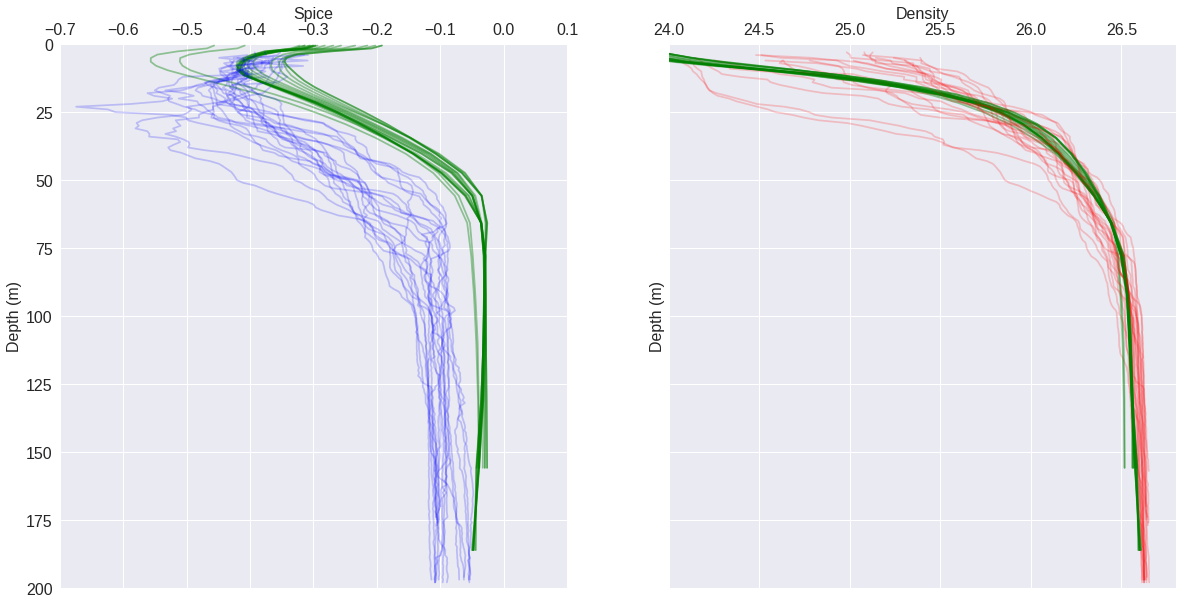

In [93]:
print("Inside the Tully Canyon")

model_maxdepth_spic[model_maxdepth_spic < -10] = np.nan
model_maxdepth_rho[model_maxdepth_rho - 1000 < 0] = np.nan
# fig2, (ax2, ax3, ax4) = plt.subplots(1,3,sharey=True,figsize=(15,8))

fig2, (ax1,ax2) = plt.subplots(1,2,sharey=True,figsize=(20,10))
# Temperature
for i in np.arange(p.shape[0]):
#     ax2.plot(model_survey_sal[:,i,i],zlevels[:], c = colors[i,:])
    ax2.plot(p_den_max_depth[:,i]-1000 ,depths_survey[:],  c = 'red', alpha = 0.2, label = 'MVP')
    ax2.plot(model_maxdepth_rho[:,i]-1000, zlevels[:], c = 'green', alpha = 0.4, label = 'NEP36')
    
ax2.set_ylabel('Depth (m)', fontsize = 16)
ax2.set_ylim(0,150)
ax2.set_ylim(ax2.get_ylim()[::-1]) 
ax2.set_xlabel('Density', fontsize = 16)
ax2.xaxis.set_label_position('top') 
ax2.xaxis.set_ticks_position('top') 
ax2.tick_params(axis='both',labelsize =16)
ax2.set_xlim(24,26.8)


for i in np.arange(p.shape[0]):
#     ax2.plot(model_survey_sal[:,i,i],zlevels[:], c = colors[i,:])
    ax1.plot(spic_max_depth[:,i] ,depths_survey[:], c = 'blue', alpha = 0.2, label = 'MVP')
    ax1.plot(model_maxdepth_spic[:,i], zlevels[:], c = 'green', alpha = 0.4, label = 'NEP36')
    
ax1.set_ylabel('Depth (m)', fontsize = 16)
ax1.set_ylim(0,200)
ax1.set_ylim(ax2.get_ylim()[::-1]) 
ax1.set_xlabel('Spice', fontsize = 16)
ax1.xaxis.set_label_position('top') 
ax1.xaxis.set_ticks_position('top') 
ax1.tick_params(axis='both',labelsize =16)
ax1.set_xlim(-0.7,0.1)


In [186]:
N_smooth = np.empty_like(barograd)

for i in np.arange(barograd.shape[1]):
    N_smooth[:,i] = smooth(barograd[:,i],25,'hanning')

In [95]:
N_smooth = np.empty_like(N_MVP)

for i in np.arange(N_MVP.shape[1]):
    N_smooth[:,i] = smooth(N_MVP[:,i],20,'hanning')

/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


(-0.0001, 0.0025)

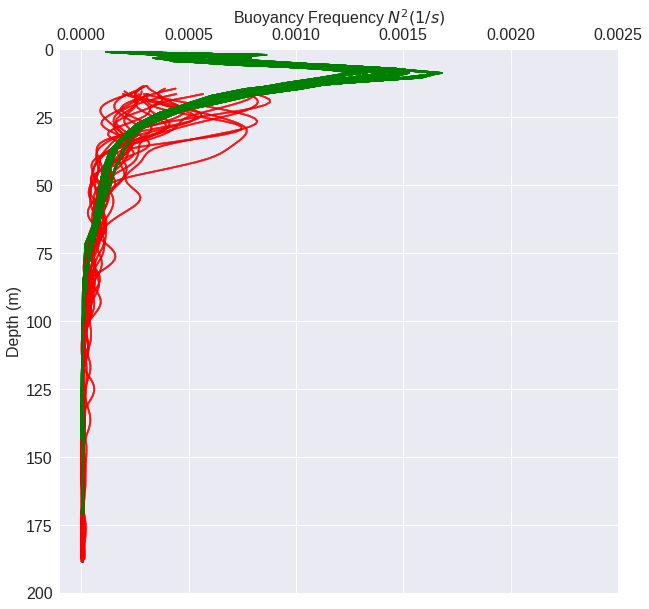

In [99]:
N_smooth[N_smooth < -0.005]  = np.nan


fig2, ax2 = plt.subplots(1,1,figsize=(10,10))
# Temperature
for i in np.arange(p.shape[0]):
    ax2.plot(N_smooth[1:,:] ,Z_N_MVP[:],  c = 'red', alpha = 0.1, label = 'MVP')
    ax2.plot(N_model[1:,:] ,Z_N_model[:], c = 'green', alpha = 0.4, label = 'NEP36')
    
ax2.set_ylabel('Depth (m)', fontsize = 16)
ax2.set_ylim(0,200)
ax2.set_ylim(ax2.get_ylim()[::-1]) 
ax2.set_xlabel('Buoyancy Frequency $N^2 (1/s)$', fontsize = 16)
ax2.xaxis.set_label_position('top') 
ax2.xaxis.set_ticks_position('top') 
ax2.tick_params(axis='both',labelsize =16)
ax2.set_xlim(-0.0001,0.0025)

In [168]:
barograd = baroclinic_pressgrad_mvp(pden=p_den_max_depth, lat_loc= lat[q[:],p[:]], lon_loc= lon[q[:],p[:]])

In [169]:
barograd_model = baroclinic_pressgrad_mvp(pden=model_maxdepth_rho, lat_loc= lat[q[:],p[:]], lon_loc= lon[q[:],p[:]])

In [19]:
mat = scipy.io.loadmat(survey_file_D)


depths_survey = mat['depths'][:,0]
lat_survey = mat['latitude'][:,0]
lon_survey = mat['longitude'][:,0] - 100
# den_survey = mat['density'][:]
pden_survey = mat['pden'][:]
temp_survey = mat['temp'][:]
sal_survey = mat['salinity'][:]
mtime = mat['mtime'][:,0]

In [ ]:
mat.keys()

In [140]:
def baroclinic_pressgrad_mvp(pden, lon_loc, lat_loc, rho_0 = 1025, g = 9.8):
    

    grad_rho = np.gradient(pden, axis = 1)
    
    dist = np.empty_like(lat_loc)
    
    for i in np.arange(0,lon_loc.shape[0]-1):
        
        dist[i] = 1000*geo_tools.haversine(lon_loc[i], lat_loc[i], lon_loc[i+1], lat_loc[i+1])
        
    drho = np.empty_like(grad_rho)
    
    for j in np.arange(grad_rho.shape[0]):
        drho[j,:] = grad_rho[j,:]
        
    baroclin_press = np.empty_like(drho)
        
    baroclin_press =(g/rho_0)*drho
    
    return baroclin_press
        
    
    
    
    
    

In [46]:
pden_survey[:,0]

grad_rho = np.gradient(pden_survey, axis = 1)

In [56]:
drho = np.empty_like(grad_rho)

for j in np.arange(grad_rho.shape[0]):
    drho[j] = grad_rho[j,:]/dist[:]

/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in true_divide


In [62]:
drho.shape

(251, 108)

In [60]:
dist[:]

array([ 1196.26619713,  1331.71160818,  1421.3390962 ,  1499.57268602,
        1516.50979591,  1468.61255594,  1425.87231104,  1377.2785331 ,
        1407.4699942 ,  1457.58319059,  1430.93717103,  1486.06313713,
        1594.9222425 ,  1600.35075683,  1433.37116401,  1499.70864273,
        1599.11634312,   108.52746978,   377.41315095,  1334.89678276,
        1417.33090702,  1203.93667174,  1129.85920121,  1072.38808979,
         945.80137748,   965.39151046,   976.86252041,   960.83958847,
         912.86165112,   864.782858  ,  1008.99025273,  1016.10461226,
         933.51269709,   882.8572335 ,   848.34213775,   766.50823841,
         733.99410955,   725.90127787,   712.13550483,   728.50948204,
         731.79895002,   727.43471266,   713.20208267,   695.86925777,
        1126.74679787,   919.00072971,   961.87442093,  1052.52381496,
        1117.96249818,  1048.69883242,   999.77830404,  1014.91674903,
        1042.43694963,  1019.81166909,   765.21455458,   919.5452868 ,
      

In [30]:
lon_survey.shape

(108,)

In [35]:
dist = 1000*geo_tools.haversine(lon_survey[:], lat_survey[:], lon_survey[:], lat_survey[:])

In [36]:
dist.shape

(108,)

In [39]:
for i in np.arange(0,lon_survey.shape[0]-1):
    dist[i] = 1000*geo_tools.haversine(lon_survey[i], lat_survey[i], lon_survey[i+1], lat_survey[i+1])

In [119]:
q = q.astype(int)
p = p.astype(int)

In [120]:
lat[q[:],p[:]]

array([ 47.356884,  47.356884,  47.356884,  47.356884,  47.356884,
        47.356884,  47.356884,  47.356884,  47.356884,  47.356884,
        47.356884,  47.356884,  47.356884,  47.356884,  47.356884,
        47.356884,  47.356884,  47.356884,  47.356884,  47.356884,
        47.356884,  47.356884,  47.356884,  47.356884,  47.356884,
        47.356884,  47.356884,  47.356884,  47.356884,  47.356884,
        47.356884,  47.356884,  47.356884,  47.356884,  47.356884,
        47.356884,  47.356884,  47.356884,  47.356884,  47.356884,
        47.356884,  47.356884,  47.356884,  47.356884,  47.356884,
        47.356884,  47.356884,  47.356884,  47.356884,  47.356884,
        47.356884,  47.356884], dtype=float32)

In [121]:
pden=p_den_max_depth
lat_loc= lat[q[:],p[:]]
lon_loc= lon[q[:],p[:]]

In [103]:
grad_rho = np.gradient(pden, axis = 1)

In [136]:
dist = np.empty_like(lat_loc)

for i in np.arange(0,lon_loc.shape[0]-1):

    dist[i] = 1000*geo_tools.haversine(lon_loc[i], lat_loc[i], lon_loc[i+1], lat_loc[i+1])

In [139]:
dist[:]

array([  0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
         0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
         0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
         0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
         0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
         0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
         0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
         0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
         0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
         0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
         0.      ,  47.356884], dtype=float32)

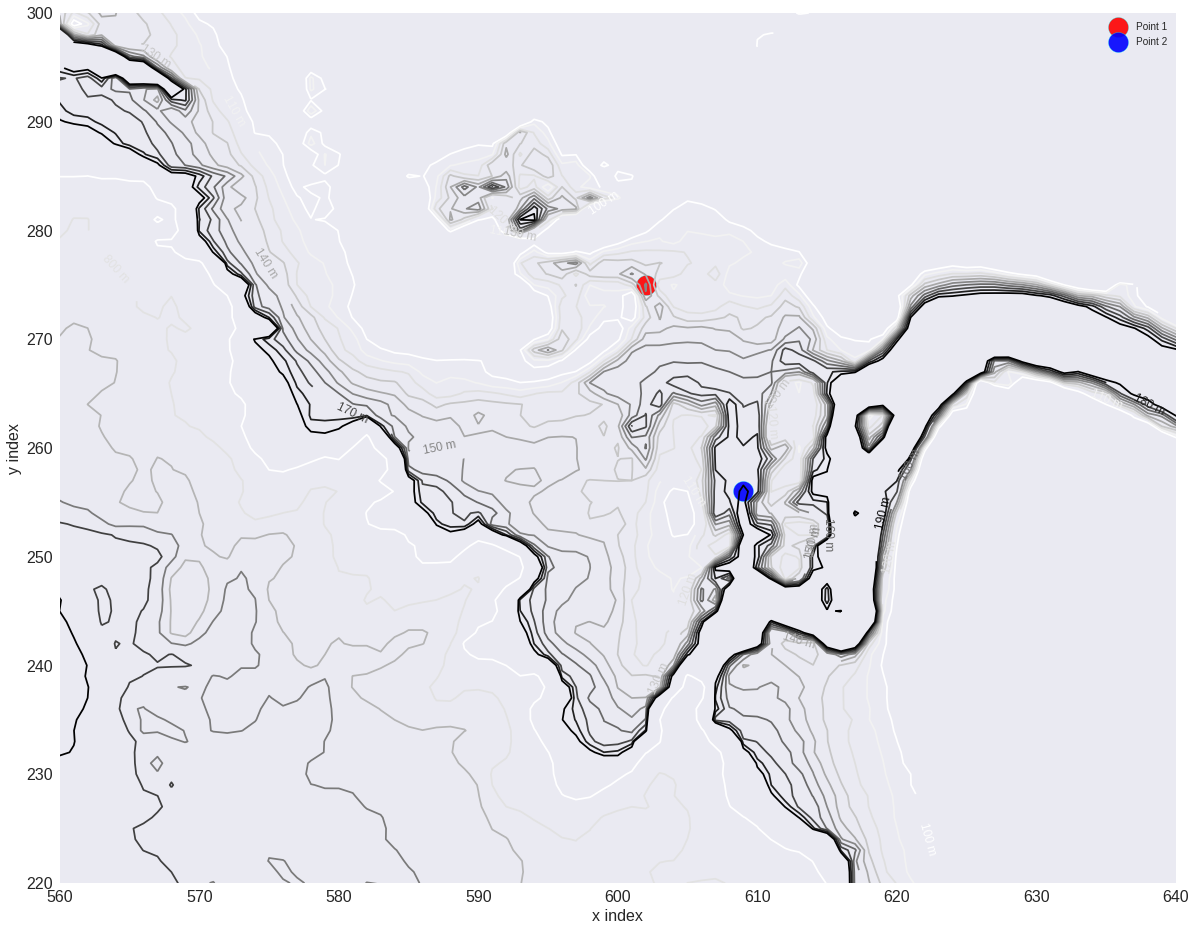

In [140]:
colors = cmo.cm.phase(np.linspace(0, 1, p.shape[0]))
# # plt.style.use('default')

# sns.set_context('paper')
# sns.set_color_codes()
# plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}
# plt.style.use('seaborn')

cmap = cmo.cm.deep
#     cmap.set_bad('burlywood')
cmap.set_bad('#8b7765')

fig, ax = plt.subplots(1, 1, figsize=(20,16)); ax.grid()
#     ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=np.mean(lon)))
CS = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[:,:], np.arange(100,200,10))
CS1 = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[:,:], level = [0,500,1000], color = 'k' )
CLS = plt.clabel(CS, inline=3,fmt='%0.0f m', fontsize=12)
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)




# for i in np.arange(p.shape[0]):

ax.scatter(x_wcvi_slice[np.int(p[0])], y_wcvi_slice[np.int(q[0])], c = 'Red', cmap = cmap, s=400, alpha=0.9, edgecolor= 'cyan', label = 'Point 1' )

ax.scatter(x_wcvi_slice[np.int(p[-1])], y_wcvi_slice[np.int(q[-1])], c = 'Blue', cmap = cmap, s=400, alpha=0.9, edgecolor= 'cyan', label = 'Point 2' )


ax.set_ylim(220,300)
ax.set_xlim(560,640)
    
ax.set_xlabel('x index', fontsize =16)
ax.set_ylabel('y index', fontsize = 16)
ax.tick_params(axis='both',labelsize =16)
ax.legend(loc = 'best')


In [141]:
q = q.astype(int)
p = p.astype(int)



pden_2_points = np.transpose(np.array([p_den_max_depth[:,0], p_den_max_depth[:,-1]]))

lat_2_points = np.transpose(np.array([lat[q[0],p[0]], lat[q[-1],p[-1]]]))

lon_2_points = np.transpose(np.array([lon[q[0],p[0]], lon[q[-1],p[-1]]]))


pden_2_points_model = np.transpose(np.array([model_maxdepth_rho[:,0], model_maxdepth_rho[:,-1]]))


In [20]:
grad_rho = np.gradient(pden_2_points, axis = 1)

grad_rho = np.nanmean(grad_rho, axis=1)

dist = np.empty_like(lat_2_points)

dist = 1000*geo_tools.haversine(lon_2_points[0], lat_2_points[0], lon_2_points[-1], lat_2_points[-1])

drho = np.empty_like(grad_rho)

for j in np.arange(grad_rho.shape[0]):
    drho[j] = (grad_rho[j]/dist)*depths_survey[j]
    
    
g = 9.8
rho_0 = 1025
baroclin_press = (g/rho_0)*drho

/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()


In [193]:
def get_baro_clinic_p_gradient(p_2_points, lat_2_points, lon_2_points, g = 9.8, rho_0 = 1025):
    
    grad_rho = np.gradient(p_2_points, axis = 1)

    grad_rho = np.nanmean(grad_rho, axis=1)

    dist = np.empty_like(lat_2_points)

    dist = 1000*geo_tools.haversine(lon_2_points[0], lat_2_points[0], lon_2_points[-1], lat_2_points[-1])

    drho = np.empty_like(grad_rho)

    for j in np.arange(1,grad_rho.shape[0]):
        drho[j] = (grad_rho[j]/dist)
        
    drho = np.nancumsum(drho)
        
    return drho
    
    

In [27]:
baroclin_press = get_baro_clinic_p_gradient(p_2_points = pden_2_points, lat_2_points=lat_2_points,\
                                            lon_2_points=lon_2_points)

/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: Mean of empty slice


In [143]:
def get_baro_clinic_p_gradient_model(p_2_points, lat_2_points, lon_2_points, g = 9.8, rho_0 = 1025):
    
    grad_rho = np.gradient(p_2_points, axis = 1)

    grad_rho = np.nanmean(grad_rho, axis=1)
    
    grad_rho = grad_rho[np.nonzero(grad_rho)]
    

    dist = np.empty_like(lat_2_points)

    dist = 1000*geo_tools.haversine(lon_2_points[0], lat_2_points[0], lon_2_points[-1], lat_2_points[-1])

    drho = np.empty_like(grad_rho)

    for j in np.arange(1,grad_rho.shape[0]):
        drho[j] = (grad_rho[j]/dist)*(zlevels[j]-zlevels[j-1])
    drho = np.cumsum(drho)
        
    return drho
    
    

In [144]:
baroclin_press = get_baro_clinic_p_gradient(p_2_points = pden_2_points, lat_2_points=lat_2_points,\
                                            lon_2_points=lon_2_points)

barograd_model = get_baro_clinic_p_gradient_model(p_2_points=pden_2_points_model, lat_2_points=lat_2_points,\
                                            lon_2_points=lon_2_points)

/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: Mean of empty slice


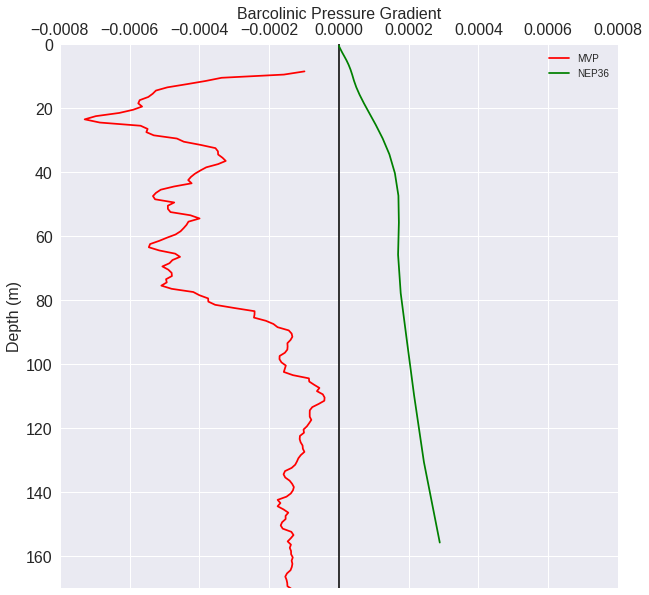

In [145]:
fig2, ax2 = plt.subplots(1,1,figsize=(10,10))

ax2.plot(baroclin_press[1:] ,Z_N_MVP[:],  c = 'red',  label = 'MVP')
  
ax2.plot(barograd_model[:-1] , zlevels[:barograd_model.shape[0]-1], c = 'green', label = 'NEP36')

ax2.set_ylabel('Depth (m)', fontsize = 16)
ax2.set_ylim(0,170)
ax2.set_ylim(ax2.get_ylim()[::-1]) 
ax2.set_xlabel('Barcolinic Pressure Gradient', fontsize = 16)
ax2.xaxis.set_label_position('top') 
ax2.xaxis.set_ticks_position('top') 
ax2.tick_params(axis='both',labelsize =16)
ax2.set_xlim(-0.0008,0.0008)
ax2.vlines(x = 0, ymin=ax2.get_ylim(), ymax = 0)
ax2.legend(loc= 'best')

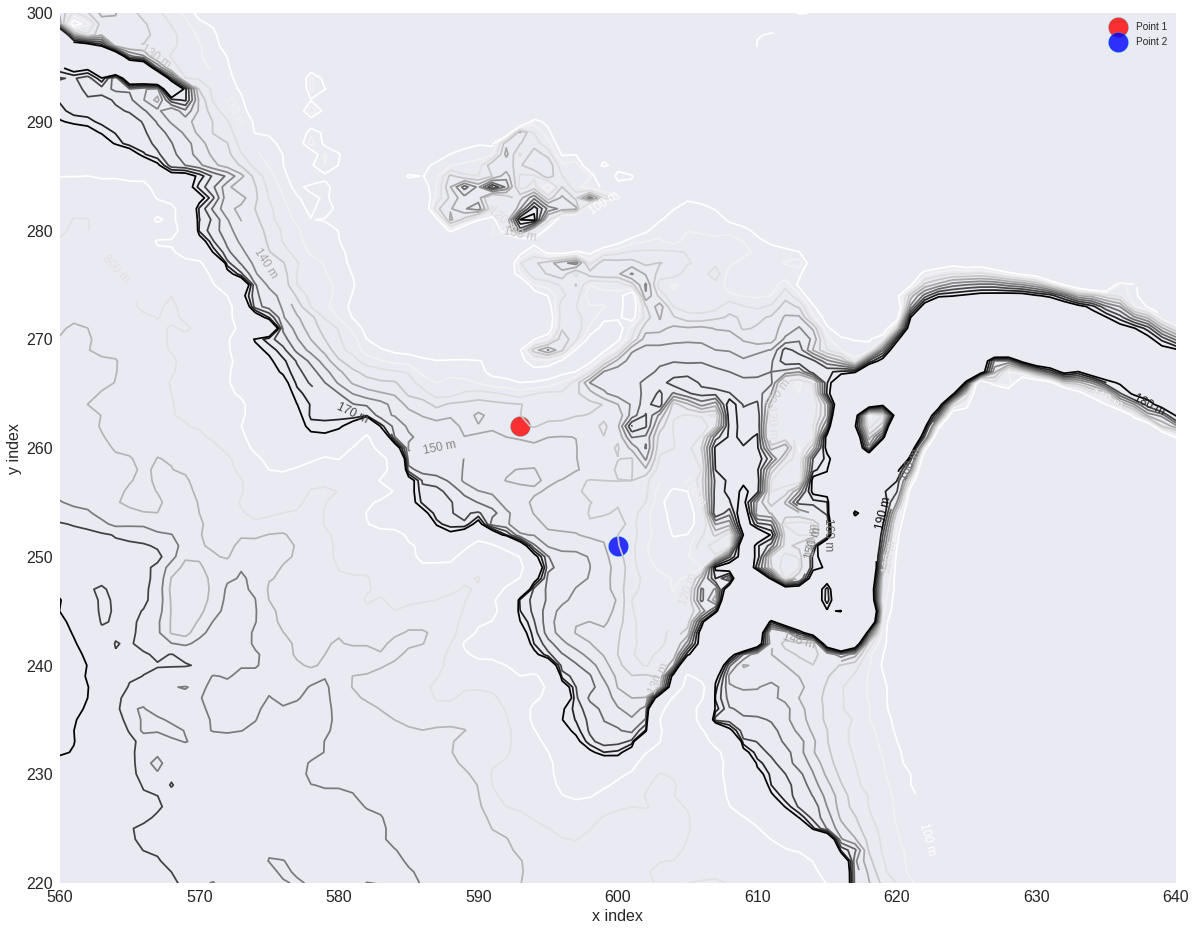

In [96]:
colors = cmo.cm.phase(np.linspace(0, 1, p.shape[0]))
# # plt.style.use('default')

# sns.set_context('paper')
# sns.set_color_codes()
# plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}
# plt.style.use('seaborn')

cmap = cmo.cm.deep
#     cmap.set_bad('burlywood')
cmap.set_bad('#8b7765')

fig, ax = plt.subplots(1, 1, figsize=(20,16)); ax.grid()
#     ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=np.mean(lon)))
CS = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[:,:], np.arange(100,200,10))
CS1 = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[:,:], level = [0,500,1000], color = 'k' )
CLS = plt.clabel(CS, inline=3,fmt='%0.0f m', fontsize=12)
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)





ax.scatter(x_wcvi_slice[np.int(p[0])], y_wcvi_slice[np.int(q[0])], c = 'Red', cmap = cmap, s=400, alpha=0.8, edgecolor= 'cyan', label = 'Point 1')

ax.scatter(x_wcvi_slice[np.int(p[-1])], y_wcvi_slice[np.int(q[-1])], c = 'Blue', cmap = cmap, s=400, alpha=0.8, edgecolor= 'cyan', label = 'Point 2' )

ax.set_ylim(220,300)
ax.set_xlim(560,640)
    
ax.set_xlabel('x index', fontsize =16)
ax.set_ylabel('y index', fontsize = 16)
ax.tick_params(axis='both',labelsize =16)
ax.legend(loc = 'best')

In [ ]:
lon_max_depth = lon_survey[np.where((max_depths < np.mean(max_depths)) & (max_depths > 118))]
lat_max_depth = lat_survey[np.where((max_depths < np.mean(max_depths)) & (max_depths > 118))]
p_den_max_depth = pden_survey[:,np.where((max_depths < np.mean(max_depths)) & (max_depths > 118))]
p_den_max_depth = p_den_max_depth[:,0,:]
temp_den_max_depth = temp_survey[:,np.where((max_depths < np.mean(max_depths)) & (max_depths > 118))]
temp_den_max_depth = temp_den_max_depth[:,0,:]
sal_den_max_depth = sal_survey[:,np.where((max_depths < np.mean(max_depths)) & (max_depths > 118))]
sal_den_max_depth = sal_den_max_depth[:,0,:]



In [89]:
pressure = np.empty_like(sal_den_max_depth)
SA = np.empty_like(pressure)
CT = np.empty_like(SA)
spic_max_depth = np.empty_like(SA)
N_MVP = np.empty_like(SA)
pmid = np.empty_like(N_MVP)
Z_N_MVP = np.empty((pmid.shape[0]-1))


for j in np.arange(depths_survey.shape[0]):

    for i in np.arange(p.shape[0]):

        pressure[j,i] = gsw.p_from_z(-depths_survey[j],lat_max_depth[i])

        SA[j,i] = gsw.SA_from_SP(sal_den_max_depth[j,i], pressure[j,i], lon_max_depth[i], lat_max_depth[i])

        CT[j,i] = gsw.CT_from_pt(sal_den_max_depth[j,i], temp_den_max_depth[j,i])

        spic_max_depth[j,i] = gsw.spiciness0(SA[j,i], CT[j,i])
        
        
for i in np.arange(p.shape[0]): 
    N_MVP[1:,i],pmid[1:,i] = gsw.stability.Nsquared(SA[:,i], CT[:,i], pressure[:,i], lat_max_depth[0])
    
Z_N_MVP[:] = -gsw.z_from_p(pmid[1:,0], lat_max_depth[0])

model_maxdepth_sal = np.empty((sal.shape[1],q.shape[0]))
model_maxdepth_temp = np.empty_like(model_maxdepth_sal)
model_maxdepth_rho = np.empty_like(model_maxdepth_sal)
model_maxdepth_spic = np.empty_like(model_maxdepth_sal)

t = 116



for i in np.arange(p.shape[0]):
    model_maxdepth_sal[:,i]   = sal[t,:,q[i],p[i]]
    model_maxdepth_temp[:,i]  = temp[t,:,q[i],p[i]]
    model_maxdepth_spic[:,i]  = spic[t,:,q[i],p[i]]
    model_maxdepth_rho[:,i]   = rho[t,:,q[i],p[i]]
    


pressure_model = np.empty_like(model_maxdepth_sal)
SA_model = np.empty_like(pressure_model)
CT_model = np.empty_like(SA_model)
N_model = np.empty_like(SA_model)
pmid_model = np.empty_like(N_model)
Z_N_model = np.empty((pmid_model.shape[0]-1))
    
for j in np.arange(model_maxdepth_sal.shape[0]):

    for i in np.arange(model_maxdepth_sal.shape[1]):

        pressure_model[j,i] = gsw.p_from_z(-zlevels[j],lat_max_depth[0])

        SA_model[j,i] = gsw.SA_from_SP(model_maxdepth_sal[j,i], pressure_model[j,i], lon_max_depth[i], lat_max_depth[i])

        CT_model[j,i] = gsw.CT_from_pt(model_maxdepth_sal[j,i], model_maxdepth_temp[j,i])
    

for i in np.arange(p.shape[0]): 
    N_model[1:,i],pmid_model[1:,i] = gsw.stability.Nsquared(SA_model[:,i], CT_model[:,i], pressure_model[:,i], lat_max_depth[0])
    
Z_N_model[:] = -gsw.z_from_p(pmid_model[1:,0], lat_max_depth[0])

In [128]:
q = q.astype(int)
p = p.astype(int)



pden_2_points = np.transpose(np.array([p_den_max_depth[:,0], p_den_max_depth[:,-1]]))

lat_2_points = np.transpose(np.array([lat[q[0],p[0]], lat[q[-1],p[-1]]]))

lon_2_points = np.transpose(np.array([lon[q[0],p[0]], lon[q[-1],p[-1]]]))


pden_2_points_model = np.transpose(np.array([model_maxdepth_rho[:,0], model_maxdepth_rho[:,-1]]))






baroclin_press = get_baro_clinic_p_gradient(p_2_points = pden_2_points, lat_2_points=lat_2_points,\
                                            lon_2_points=lon_2_points)

barograd_model = get_baro_clinic_p_gradient_model(p_2_points=pden_2_points_model, lat_2_points=lat_2_points,\
                                            lon_2_points=lon_2_points)

/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: Mean of empty slice


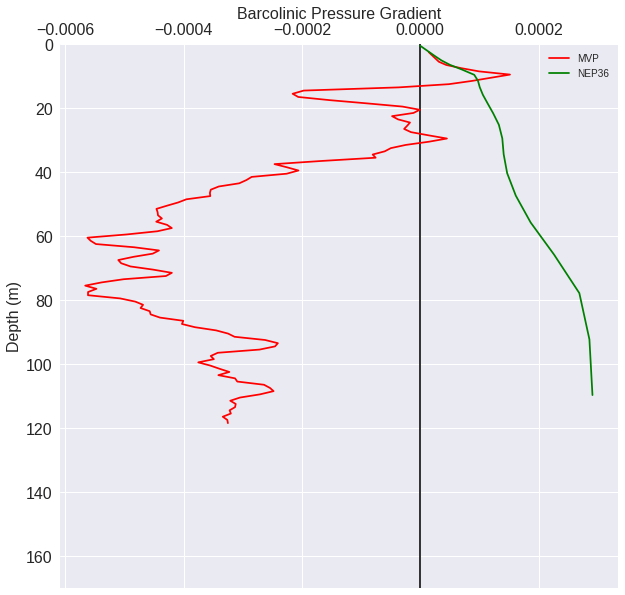

In [129]:
fig2, ax2 = plt.subplots(1,1,figsize=(10,10))

ax2.plot(baroclin_press[1:] ,Z_N_MVP[:],  c = 'red',  label = 'MVP')
  
ax2.plot(barograd_model[:-1] , zlevels[:barograd_model.shape[0]-1], c = 'green', label = 'NEP36')

ax2.set_ylabel('Depth (m)', fontsize = 16)
ax2.set_ylim(0,170)
ax2.set_ylim(ax2.get_ylim()[::-1]) 
ax2.set_xlabel('Barcolinic Pressure Gradient', fontsize = 16)
ax2.xaxis.set_label_position('top') 
ax2.xaxis.set_ticks_position('top') 
ax2.tick_params(axis='both',labelsize =16)
# ax2.set_xlim(-0.00008,0.00008)
ax2.vlines(x = 0, ymin=ax2.get_ylim(), ymax = 0)
ax2.legend(loc= 'best')

### Baroclinic Velocities in the Model are opposite to that in the MVP

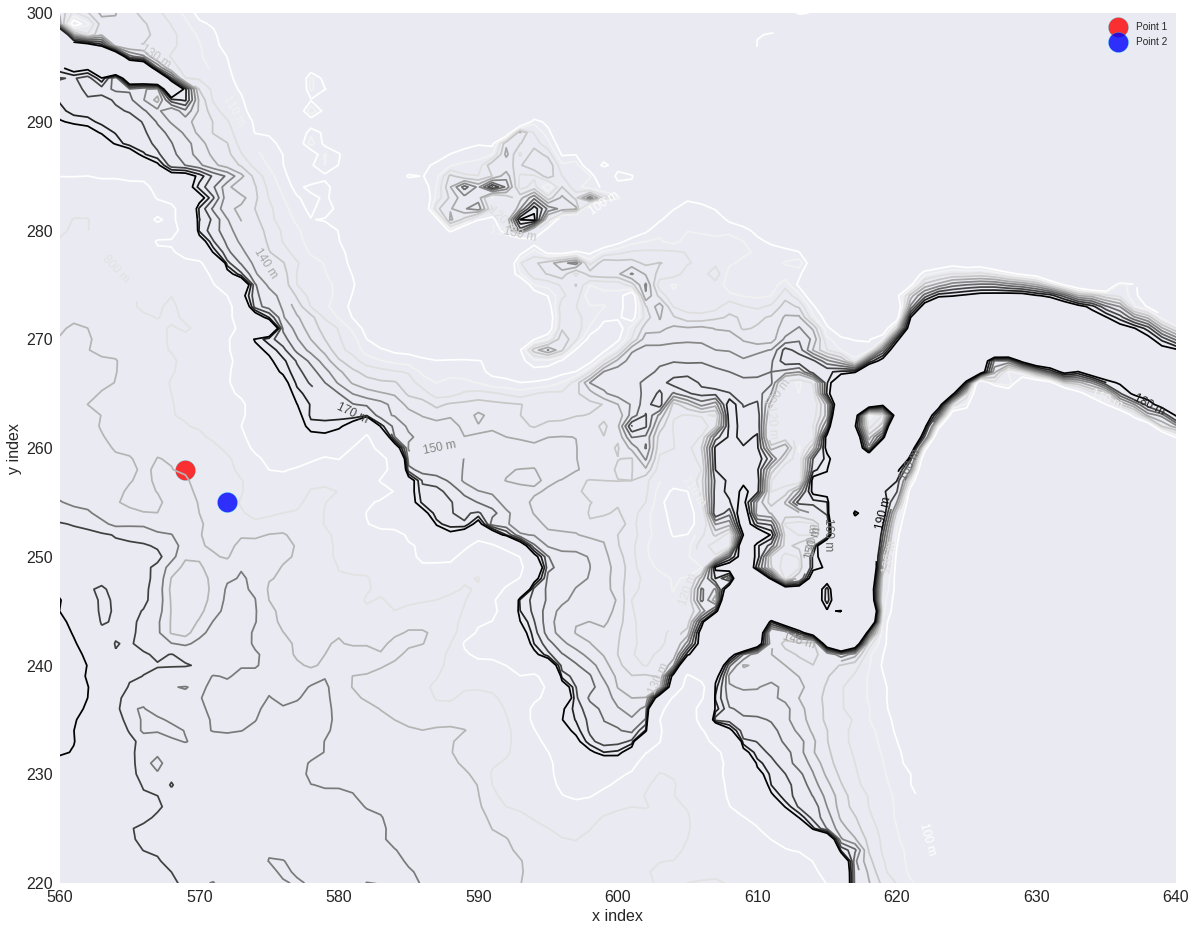

In [187]:
colors = cmo.cm.phase(np.linspace(0, 1, p.shape[0]))
# # plt.style.use('default')

# sns.set_context('paper')
# sns.set_color_codes()
# plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}
# plt.style.use('seaborn')

cmap = cmo.cm.deep
#     cmap.set_bad('burlywood')
cmap.set_bad('#8b7765')

fig, ax = plt.subplots(1, 1, figsize=(20,16)); ax.grid()
#     ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=np.mean(lon)))
CS = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[:,:], np.arange(100,200,10))
CS1 = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[:,:], level = [0,500,1000], color = 'k' )
CLS = plt.clabel(CS, inline=3,fmt='%0.0f m', fontsize=12)
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)




ax.scatter(x_wcvi_slice[np.int(p[0])], y_wcvi_slice[np.int(q[0])], c = 'Red', cmap = cmap, s=400, alpha=0.8, edgecolor= 'cyan', label = 'Point 1')

ax.scatter(x_wcvi_slice[np.int(p[-1])], y_wcvi_slice[np.int(q[-1])], c = 'Blue', cmap = cmap, s=400, alpha=0.8, edgecolor= 'cyan', label = 'Point 2' )



ax.set_ylim(220,300)
ax.set_xlim(560,640)
    
ax.set_xlabel('x index', fontsize =16)
ax.set_ylabel('y index', fontsize = 16)
ax.tick_params(axis='both',labelsize =16)

ax.legend(loc = 'best')


In [188]:
pressure = np.empty_like(sal_den_max_depth)
SA = np.empty_like(pressure)
CT = np.empty_like(SA)
spic_max_depth = np.empty_like(SA)
N_MVP = np.empty_like(SA)
pmid = np.empty_like(N_MVP)
Z_N_MVP = np.empty((pmid.shape[0]-1))


for j in np.arange(depths_survey.shape[0]):

    for i in np.arange(p.shape[0]):

        pressure[j,i] = gsw.p_from_z(-depths_survey[j],lat_max_depth[i])

        SA[j,i] = gsw.SA_from_SP(sal_den_max_depth[j,i], pressure[j,i], lon_max_depth[i], lat_max_depth[i])

        CT[j,i] = gsw.CT_from_pt(sal_den_max_depth[j,i], temp_den_max_depth[j,i])

        spic_max_depth[j,i] = gsw.spiciness0(SA[j,i], CT[j,i])
        
        
for i in np.arange(p.shape[0]): 
    N_MVP[1:,i],pmid[1:,i] = gsw.stability.Nsquared(SA[:,i], CT[:,i], pressure[:,i], lat_max_depth[0])
    
Z_N_MVP[:] = -gsw.z_from_p(pmid[1:,0], lat_max_depth[0])

model_maxdepth_sal = np.empty((sal.shape[1],q.shape[0]))
model_maxdepth_temp = np.empty_like(model_maxdepth_sal)
model_maxdepth_rho = np.empty_like(model_maxdepth_sal)
model_maxdepth_spic = np.empty_like(model_maxdepth_sal)

t = 119



for i in np.arange(p.shape[0]):
    model_maxdepth_sal[:,i]   = sal[t,:,q[i],p[i]]
    model_maxdepth_temp[:,i]  = temp[t,:,q[i],p[i]]
    model_maxdepth_spic[:,i]  = spic[t,:,q[i],p[i]]
    model_maxdepth_rho[:,i]   = rho[t,:,q[i],p[i]]
    


pressure_model = np.empty_like(model_maxdepth_sal)
SA_model = np.empty_like(pressure_model)
CT_model = np.empty_like(SA_model)
N_model = np.empty_like(SA_model)
pmid_model = np.empty_like(N_model)
Z_N_model = np.empty((pmid_model.shape[0]-1))
    
for j in np.arange(model_maxdepth_sal.shape[0]):

    for i in np.arange(model_maxdepth_sal.shape[1]):

        pressure_model[j,i] = gsw.p_from_z(-zlevels[j],lat_max_depth[0])

        SA_model[j,i] = gsw.SA_from_SP(model_maxdepth_sal[j,i], pressure_model[j,i], lon_max_depth[i], lat_max_depth[i])

        CT_model[j,i] = gsw.CT_from_pt(model_maxdepth_sal[j,i], model_maxdepth_temp[j,i])
    

for i in np.arange(p.shape[0]): 
    N_model[1:,i],pmid_model[1:,i] = gsw.stability.Nsquared(SA_model[:,i], CT_model[:,i], pressure_model[:,i], lat_max_depth[0])
    
Z_N_model[:] = -gsw.z_from_p(pmid_model[1:,0], lat_max_depth[0])

In [194]:
def get_baro_clinic_p_gradient(p_2_points, lat_2_points, lon_2_points, g = 9.8, rho_0 = 1025):
    
    grad_rho = np.gradient(p_2_points, axis = 1)

    grad_rho = np.nanmean(grad_rho, axis=1)

    dist = np.empty_like(lat_2_points)

    dist = 1000*geo_tools.haversine(lon_2_points[0], lat_2_points[0], lon_2_points[-1], lat_2_points[-1])

    drho = np.empty_like(grad_rho)

    for j in np.arange(1,grad_rho.shape[0]):
        drho[j] = (grad_rho[j]/dist)
#         
    drho = np.nancumsum(drho)
        
    return drho
    
    

In [195]:
def get_baro_clinic_p_gradient_model(p_2_points, lat_2_points, lon_2_points, g = 9.8, rho_0 = 1025):
    
    grad_rho = np.gradient(p_2_points, axis = 1)

    grad_rho = np.nanmean(grad_rho, axis=1)
    
    grad_rho = grad_rho[np.nonzero(grad_rho)]
    

    dist = np.empty_like(lat_2_points)

    dist = 1000*geo_tools.haversine(lon_2_points[0], lat_2_points[0], lon_2_points[-1], lat_2_points[-1])

    drho = np.empty_like(grad_rho)

    for j in np.arange(1,grad_rho.shape[0]):
        drho[j] = (grad_rho[j]/dist)*(zlevels[j]-zlevels[j-1])
        
    drho = np.nancumsum(drho)
        
    return drho
    
    

In [196]:
q = q.astype(int)
p = p.astype(int)



pden_2_points = np.transpose(np.array([p_den_max_depth[:,0], p_den_max_depth[:,-1]]))

lat_2_points = np.transpose(np.array([lat[q[0],p[0]], lat[q[-1],p[-1]]]))

lon_2_points = np.transpose(np.array([lon[q[0],p[0]], lon[q[-1],p[-1]]]))


pden_2_points_model = np.transpose(np.array([model_maxdepth_rho[:,0], model_maxdepth_rho[:,-1]]))






baroclin_press = get_baro_clinic_p_gradient(p_2_points = pden_2_points, lat_2_points=lat_2_points,\
                                            lon_2_points=lon_2_points)

barograd_model = get_baro_clinic_p_gradient_model(p_2_points=pden_2_points_model, lat_2_points=lat_2_points,\
                                            lon_2_points=lon_2_points)

/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: Mean of empty slice


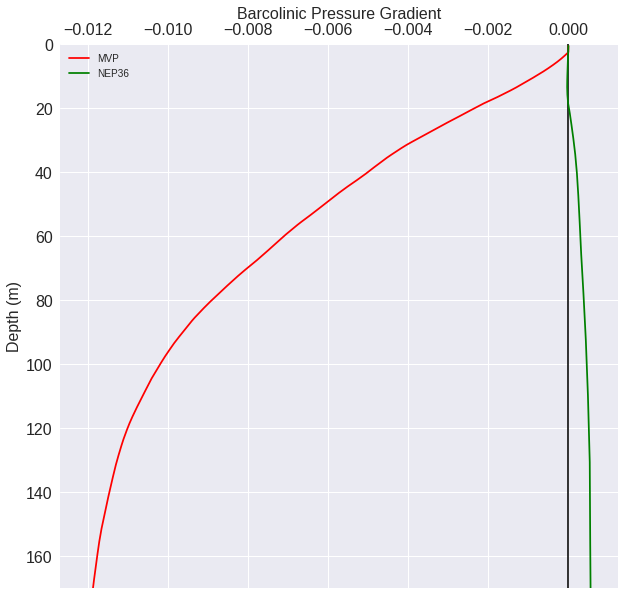

In [197]:
fig2, ax2 = plt.subplots(1,1,figsize=(10,10))

ax2.plot(baroclin_press[1:] ,Z_N_MVP[:],  c = 'red',  label = 'MVP')
  
ax2.plot(barograd_model[:-1] , zlevels[:barograd_model.shape[0]-1], c = 'green', label = 'NEP36')

ax2.set_ylabel('Depth (m)', fontsize = 16)
ax2.set_ylim(0,170)
ax2.set_ylim(ax2.get_ylim()[::-1]) 
ax2.set_xlabel('Barcolinic Pressure Gradient', fontsize = 16)
ax2.xaxis.set_label_position('top') 
ax2.xaxis.set_ticks_position('top') 
ax2.tick_params(axis='both',labelsize =16)
# ax2.set_xlim(-0.00008,0.00008)
ax2.vlines(x = 0, ymin=ax2.get_ylim(), ymax = 0)
ax2.legend(loc= 'best')